# Diabetic Discharge: Navigating Readmission Risks
#### By Rebekah McLaughlin

<p align="center">
  <img src = https://www.uclahealth.org/sites/default/files/styles/max_width_024000_960/public/images/patient-and-doctor-compassion_0.jpg?itok=lTl_75jr>
</p> 

## Overview

VitalCare Health Syste is aiming to reduce early readmission rates among diabetic patients to improve overall patient outcomes. To achieve this goal, an analysis will be conducted on a comprehensive dataset about hospitalized diabetic patients and whether they were readmitted within 30 days of discharge.

Tracking and mitigating readmission rates within 30 days of discharge serves as a critical key performance indicator for hospitals for two main reasons:

1. Firstly, an early readmission, occurring within 30 days of discharge, signals potential gaps in care that weren't addressed prior to the patient's discharge. These gaps elevate the risk of poorer patient outcomes, underlining the importance of comprehensive care continuity.

2. Secondly, early readmissions within this timeframe can cause significant financial burdens on hospitals. In addition to this, hospitals often receive only partial reimbursement from insurance providers for early readmissions.

#### **The Dataset**

The dataset includes a decade's worth of US hospital data spanning from 1999 to 2008, with over 100,000 entries, each representing a patient's hospitalization and associated details. The target is `'readmission'`. It has more than 50 features, including demographic information such as:
- age group
- gender
- race

Alongside medical specifics such as:
- diagnoses
- medications prescribed
- number of procedures during hospitalization
- other pertinent details regarding the patient's stay.

For a full description and download of the dataset, click <a href = "https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008">here</a>. Also, a full descripton of each feature label is in the Data folder.

#### **The Goal**

The goal of this project is to use the dataset to develop a model capable of accurately identifying patients who are at risk of being readmitted within 30 days of discharge.

##### **Importing libraries and loading data**

The first step is importing the necessary libraries and analysis tools. Next, I will load the dataset into a pandas dataframe.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report, recall_score
import xgboost as xgb
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE



df = pd.read_csv('./Data/diabetic_data.csv')
df

encounter_id  patient_nbr             race  gender      age weight  \
0            2278392      8222157        Caucasian  Female   [0-10)      ?   
1             149190     55629189        Caucasian  Female  [10-20)      ?   
2              64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3             500364     82442376        Caucasian    Male  [30-40)      ?   
4              16680     42519267        Caucasian    Male  [40-50)      ?   
...              ...          ...              ...     ...      ...    ...   
101761     443847548    100162476  AfricanAmerican    Male  [70-80)      ?   
101762     443847782     74694222  AfricanAmerican  Female  [80-90)      ?   
101763     443854148     41088789        Caucasian    Male  [70-80)      ?   
101764     443857166     31693671        Caucasian  Female  [80-90)      ?   
101765     443867222    175429310        Caucasian    Male  [70-80)      ?   

        admission_type_id  discharge_disposition_id  admission_source_id  \
0                       6                        25                    1   
1                       1                         1                    7   
2                       1                         1                    7   
3                       1                         1                    7   
4                       1                         1                    7   
...                   ...                       ...                  ...   
101761                  1                         3                    7   
101762                  1                         4                    5   
101763                  1                         1                    7   
101764                  2                         3                    7   
101765                  1                         1                    7   

        time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
0                      1  ...          No      No                   No   
1                      3  ...          No      Up                   No   
2                      2  ...          No      No                   No   
3                      2  ...          No      Up                   No   
4                      1  ...          No  Steady                   No   
...                  ...  ...         ...     ...                  ...   
101761                 3  ...          No    Down                   No   
101762                 5  ...          No  Steady                   No   
101763                 1  ...          No    Down                   No   
101764                10  ...          No      Up                   No   
101765                 6  ...          No      No                   No   

        glipizide-metformin  glimepiride-pioglitazone  \
0                        No                        No   
1                        No                        No   
2                        No                        No   
3                        No                        No   
4                        No                        No   
...                     ...                       ...   
101761                   No                        No   
101762                   No                        No   
101763                   No                        No   
101764                   No                        No   
101765                   No                        No   

        metformin-rosiglitazone  metformin-pioglitazone  change diabetesMed  \
0                            No                      No      No          No   
1                            No                      No      Ch         Yes   
2                            No                      No      No         Yes   
3                            No                      No      Ch         Yes   
4                            No                      No      Ch         Yes   
...                         ...                     ...     ...         ...   
101761                       No

# I. Data Preparation

## 1. Initial Data Assessment

I'll take a quick  look at the details of the dataframe.

Then I'll inspect for missing values, extent of missing-ness, and near zero-variance values.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 50 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   weight                    101766 non-null  object
 6   admission_type_id         101766 non-null  int64 
 7   discharge_disposition_id  101766 non-null  int64 
 8   admission_source_id       101766 non-null  int64 
 9   time_in_hospital          101766 non-null  int64 
 10  payer_code                101766 non-null  object
 11  medical_specialty         101766 non-null  object
 12  num_lab_procedures        101766 non-null  int64 
 13  num_procedures            101766 non-null  int64 
 14  num_

In [3]:
df.columns

Index(['encounter_id', 'patient_nbr', 'race', 'gender', 'age', 'weight',
       'admission_type_id', 'discharge_disposition_id', 'admission_source_id',
       'time_in_hospital', 'payer_code', 'medical_specialty',
       'num_lab_procedures', 'num_procedures', 'num_medications',
       'number_outpatient', 'number_emergency', 'number_inpatient', 'diag_1',
       'diag_2', 'diag_3', 'number_diagnoses', 'max_glu_serum', 'A1Cresult',
       'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
       'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
       'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
       'tolazamide', 'examide', 'citoglipton', 'insulin',
       'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')

### Inspecting for missing-ness, redundancy, and near zero-variance values

In [4]:
(df.isna().sum() / len(df)) * 100

encounter_id                 0.000000
patient_nbr                  0.000000
race                         0.000000
gender                       0.000000
age                          0.000000
weight                       0.000000
admission_type_id            0.000000
discharge_disposition_id     0.000000
admission_source_id          0.000000
time_in_hospital             0.000000
payer_code                   0.000000
medical_specialty            0.000000
num_lab_procedures           0.000000
num_procedures               0.000000
num_medications              0.000000
number_outpatient            0.000000
number_emergency             0.000000
number_inpatient             0.000000
diag_1                       0.000000
diag_2                       0.000000
diag_3                       0.000000
number_diagnoses             0.000000
max_glu_serum               94.746772
A1Cresult                   83.277322
metformin                    0.000000
repaglinide                  0.000000
nateglinide 

In [5]:
df['payer_code'].value_counts(normalize=True)

payer_code
?     0.395574
MC    0.318761
HM    0.061651
SP    0.049201
BC    0.045742
MD    0.034707
CP    0.024890
UN    0.024055
CM    0.019034
OG    0.010151
PO    0.005817
DM    0.005395
CH    0.001435
WC    0.001327
OT    0.000934
MP    0.000776
SI    0.000540
FR    0.000010
Name: proportion, dtype: float64

In [6]:
df['weight'].value_counts(normalize=True)

weight
?            0.968585
[75-100)     0.013128
[50-75)      0.008814
[100-125)    0.006142
[125-150)    0.001425
[25-50)      0.000953
[0-25)       0.000472
[150-175)    0.000344
[175-200)    0.000108
>200         0.000029
Name: proportion, dtype: float64

#### **Missing Data Analysis**

Clearly 'max_glu_serum' and 'A1Cresult' have a concerning amount of missing values, with approximately 95% and 83% missing respectively. However, there are additional hidden missing values in the dataframe denoted as '?'. This is observed in 'payer_code', with around 40% having the value '?', and in 'weight', where approximately 97% have the value '?'.

I'll likely drop these columns due to the amount missing, but before deciding, I have a bit more analysis to complete. 

#### **Oral Diabetes Medication Analysis**

Many features in the dataframe encompass oral diabetes medications, such as `'glipizide'` and `'acarbose'`. The values in these columns are all one of the following:
- 'No'
- 'Steady'
- 'Up'
- 'Down'

The majority of patients documented in this dataframe are not prescribed most of these medications, with most medications having 95% or fewer patients taking them. 

However, previous research indicates that changing a prescribed diabetes medication can correlate with early readmission. Because of this, I'll opt not to discard these features entirely. To assess how many of these medication features exhibit near-zero variance, I will generate a report to see the percentage of patients taking each medication and the percentage of those who had changes to their prescriptions.

In [7]:
# Define the list of oral medication features
oral_medication_features = ['metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
                           'glimepiride', 'acetohexamide', 'glipizide', 'glyburide', 'tolbutamide',
                           'pioglitazone', 'rosiglitazone', 'acarbose', 'miglitol', 'troglitazone',
                           'tolazamide', 'examide', 'citoglipton', 'glyburide-metformin',
                           'glipizide-metformin', 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
                           'metformin-pioglitazone']

# Print report for each oral medication feature
for feature in oral_medication_features:
    print(f"=== {feature} ===")
    value_counts = df[feature].value_counts(dropna=False)
    total_count = value_counts.sum()
    percentages = value_counts / total_count * 100
    #print("Value Counts:")
    #print(value_counts)
    print("Percentages:")
    print(percentages)
    print()

=== metformin ===
Percentages:
metformin
No        80.358862
Steady    18.027632
Up         1.048484
Down       0.565022
Name: count, dtype: float64

=== repaglinide ===
Percentages:
repaglinide
No        98.487707
Steady     1.359983
Up         0.108091
Down       0.044219
Name: count, dtype: float64

=== nateglinide ===
Percentages:
nateglinide
No        99.309200
Steady     0.656408
Up         0.023584
Down       0.010809
Name: count, dtype: float64

=== chlorpropamide ===
Percentages:
chlorpropamide
No        99.915492
Steady     0.077629
Up         0.005896
Down       0.000983
Name: count, dtype: float64

=== glimepiride ===
Percentages:
glimepiride
No        94.899082
Steady     4.588959
Up         0.321325
Down       0.190633
Name: count, dtype: float64

=== acetohexamide ===
Percentages:
acetohexamide
No        99.999017
Steady     0.000983
Name: count, dtype: float64

=== glipizide ===
Percentages:
glipizide
No        87.534147
Steady    11.158933
Up         0.756638
Down     

#### **Oral Diabetes Medication Analysis**

Many of these medications are near zero-variance. However, since [changes](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8191889/#:~:text=Possibly%20medication%2Drelated%20readmissions%20within,dosages%20adjusted%20at%20initial%20discharge.) in diabetes medications can be critical to the target, these will be retained for potential feature engineering.

#### **Dropping duplicates, child rows, and features with large amounts of missing values**

Duplicate 'patient_nbr' values are present in the dataframe. It is impossible to determine whether the hospitalizations of these patients are related or independent. Therefore, the first instance of each patient number will be kept, and any subsequent entries with the same number will be dropped.

Next, rows with age categories '0-10' and '10-20' will be removed. The hospital focuses exclusively on adult care, so the analysis will concentrate on age groups containing only adult ages.

Finally, columns with a significant amount of missing data, irrelevant columns, and the 'race' column will be dropped. The 'race' column will be omitted as 'Caucasian' is oversampled, and efforts will be made to mitigate potential bias in this regard.

In [8]:
# Check for duplicate values in the 'patient_id' column
duplicate_patient_nbr = df[df.duplicated('patient_nbr')]

# Display the rows with duplicate 'patient_id' values
duplicate_patient_nbr

encounter_id  patient_nbr             race  gender      age weight  \
79           1070256     23043240        Caucasian  Female  [50-60)      ?   
81           1077924     21820806  AfricanAmerican    Male  [50-60)      ?   
143          2309376     41606064        Caucasian    Male  [20-30)      ?   
175          2552952     86240259        Caucasian  Female  [70-80)      ?   
307          3174918      5332491            Other  Female  [60-70)      ?   
...              ...          ...              ...     ...      ...    ...   
101760     443847176     50375628  AfricanAmerican  Female  [60-70)      ?   
101761     443847548    100162476  AfricanAmerican    Male  [70-80)      ?   
101762     443847782     74694222  AfricanAmerican  Female  [80-90)      ?   
101763     443854148     41088789        Caucasian    Male  [70-80)      ?   
101764     443857166     31693671        Caucasian  Female  [80-90)      ?   

        admission_type_id  discharge_disposition_id  admission_source_id  \
79                      2                         1                    4   
81                      1                         6                    7   
143                     2                         1                    2   
175                     1                         3                    7   
307                     6                        25                    7   
...                   ...                       ...                  ...   
101760                  1                         1                    7   
101761                  1                         3                    7   
101762                  1                         4                    5   
101763                  1                         1                    7   
101764                  2                         3                    7   

        time_in_hospital  ... citoglipton insulin  glyburide-metformin  \
79                     3  ...          No  Steady                   No   
81                     3  ...          No      No                   No   
143                    2  ...          No  Steady                   No   
175                   11  ...          No      Up                   No   
307                    5  ...          No  Steady                   No   
...                  ...  ...         ...     ...                  ...   
101760                 6  ...          No    Down                   No   
101761                 3  ...          No    Down                   No   
101762                 5  ...          No  Steady                   No   
101763                 1  ...          No    Down                   No   
101764                10  ...          No      Up                   No   

        glipizide-metformin  glimepiride-pioglitazone  \
79                       No                        No   
81                       No                        No   
143                      No                        No   
175                      No                        No   
307                      No                        No   
...                     ...                       ...   
101760                   No                        No   
101761                   No                        No   
101762                   No                        No   
101763                   No                        No   
101764                   No                        No   

        metformin-rosiglitazone  metformin-pioglitazone  change diabetesMed  \
79                           No                      No      No         Yes   
81                           No                      No      No          No   
143                          No                      No      No         Yes   
175                          No                      No      Ch         Yes   
307                          No                      No      No         Yes   
...                         ...                     ...     ...         ...   
101760                       No

In [9]:
df = df.drop_duplicates(subset=['patient_nbr'], keep='first')

In [10]:
df = df.drop(columns=['max_glu_serum', 'A1Cresult', 'payer_code', 'weight', 'medical_specialty', 'encounter_id', 'patient_nbr', 'race'])

In [11]:
df['age'].value_counts()

age
[70-80)     18210
[60-70)     15960
[50-60)     12466
[80-90)     11589
[40-50)      6878
[30-40)      2699
[90-100)     1900
[20-30)      1127
[10-20)       535
[0-10)        154
Name: count, dtype: int64

In [12]:
# Drop rows where the value in the 'age' column is either '[0-10)' or '[10-20)'
df = df[~df['age'].isin(['[0-10)', '[10-20)'])]

## 2. Data Cleaning, feature numerical code replacements, and feature engineering 

Before proceeding to exploratory data analysis (EDA), it is necessary to perform some cleaning. This includes replacing numerical codes with their corresponding meanings in certain columns.

For instance, all diagnoses in 'diag_1', 'diag_2', and 'diag_3' are represented by numerical values, each corresponding to a specific diagnosis. Similarly, 'admission_type_id', 'admission_source_id', and 'discharge_disposition_id' contain codes that represent descriptions. These numerical codes will be replaced with phrases summarizing their descriptions.

Diagnosis code details can be found <a href = "https://www.cms.gov/medicare/coordination-benefits-recovery/overview/icd-code-lists">here</a>.

In [13]:
df['diag_1'].value_counts()
unique_diag_1_values = [df['diag_1'].value_counts()]
unique_diag_1_values[:50]

[diag_1
 414       5233
 428       3979
 786       3039
 410       2902
 486       2430
           ... 
 848          1
 250.51       1
 691          1
 834          1
 V51          1
 Name: count, Length: 696, dtype: int64]

In [14]:
# Replace diagnoses with category names
# Circulatory: 390-459, 785 Cardiac/vascular disease
# Respiratory: 460-519, 786 Respiratory tract disease
# Digestive: 520-579, 787 Diseases of the digestive system
# Diabetes: 250.xx Diabetes mellitus
# Injury: 800-999 Injury and poisoning
# Musculoskeletal: 710-739 Diseases of the musculoskeletal system and/or connective tissue
# Genitourinary: 580-629, 788 Diseases of the genitourinary system
# Neoplasms: 140-239 Neoplasms
# Pregnacy: 630–679 Complications of pregnancy or childbirth
# Other: 780, 781, 784, 790-799, 240-279 except 250, 680-709, 782, 001-139, 290-319, E-V (beginning with a letter), 280-289, 320-359, 630-679, 360-389, 740-759

def categorize_diagnosis(diag):
    if diag.isnumeric():
        diag = int(diag)
        if diag in range(390,460) or diag==785:
            return 'Circulatory'
        elif diag in range(460,520) or diag==786:
            return 'Respiratory'
        elif diag in range(520,580) or diag==787:
            return 'Digestive'
        elif diag in np.arange(250,260,0.01):
            return 'Diabetes'
        elif diag in range(800,1000):
            return 'Injury'
        elif diag in range(710,740):
            return  'Musculoskeletal'
        elif diag in range(580,630) or diag==788:
            return  'Genitourinary'
        elif diag in range(140,240):
            return  'Neoplasms'
        elif diag in range(630-680):
            return 'Pregnancy'
        else:
            return 'Other'
    else:
        if "250" in diag:
            return 'Diabetes'
        else:
            return  'Other'

In [15]:
df['diag_1_type'] = df.apply(lambda row: categorize_diagnosis(row['diag_1']), axis=1)
df['diag_2_type'] = df.apply(lambda row: categorize_diagnosis(row['diag_2']), axis=1)
df['diag_3_type'] = df.apply(lambda row: categorize_diagnosis(row['diag_3']), axis=1)

# Remove original diagnosis features
df.drop(columns=['diag_1', 'diag_2', 'diag_3'], inplace=True)

In [16]:
display(df['diag_1_type'].value_counts())
display(df['diag_2_type'].value_counts())
display(df['diag_3_type'].value_counts())

diag_1_type
Circulatory        21888
Other              12272
Respiratory         9743
Digestive           6555
Diabetes            5290
Injury              4760
Musculoskeletal     4077
Genitourinary       3505
Neoplasms           2739
Name: count, dtype: int64

diag_2_type
Circulatory        22524
Other              18190
Diabetes            9669
Respiratory         7220
Genitourinary       5449
Digestive           2885
Injury              1848
Neoplasms           1749
Musculoskeletal     1295
Name: count, dtype: int64

diag_3_type
Circulatory        21301
Other              21094
Diabetes           12610
Respiratory         4842
Genitourinary       4186
Digestive           2724
Injury              1435
Musculoskeletal     1376
Neoplasms           1261
Name: count, dtype: int64

#### **Primary known diagnosis feature engineering**

Replacing the codes with the categories gave a meaningful label to most patients' diagnoses, but the category 'Other' still constitutes a significant portion of them.

To make this data more meaningful, a new feature called 'primary_diagnosis' will be created. This feature will contain the value from 'diag_1_type' unless it is 'Other'. If 'diag_1_type' is 'Other', then the value will be taken from 'diag_2_type'. However, if 'diag_2_type' is also 'Other', the value will be filled with the value from 'diag_3_type', regardless of if it is 'Other' or another value.

Thus, 'primary_diagnosis' will hold the value of the first known diagnosis for the patient, unless all three diagnoses are categorized as 'Other'.

In [17]:
# Define a function to determine the primary known diagnosis
def determine_primary_diagnosis(row):
    if row['diag_1_type'] != 'Other':
        return row['diag_1_type']
    elif row['diag_2_type'] != 'Other':
        return row['diag_2_type']
    else:
        return row['diag_3_type']


# Create the 'primary_diagnosis' column using the defined function
df['primary_diagnosis'] = df.apply(determine_primary_diagnosis, axis=1)


df = df.drop(columns=['diag_1_type', 'diag_2_type', 'diag_3_type'])

df['primary_diagnosis'].value_counts()

primary_diagnosis
Circulatory        24926
Respiratory        10890
Diabetes            8488
Digestive           7254
Injury              5168
Genitourinary       4973
Musculoskeletal     4411
Neoplasms           3153
Other               1566
Name: count, dtype: int64

#### **Replacing Admission and Discharge feature codes with meanings**

The admission and discharge columns originally contain values that are numerical and represent a category. I will be replacing the nummeric codes with the most pertinent category or category summary. To see the codes and their meanings, please refer to the links below.

[Admission Types]("https://raw.githubusercontent.com/bluerose98/diabetic_data/main/admission_type.csv")

[Admission Sources]("https://raw.githubusercontent.com/bluerose98/diabetic_data/main/admission_source.csv")

[Discharge Dispositions]("https://raw.githubusercontent.com/bluerose98/diabetic_data/main/discharge.csv")

In [18]:
df['admission_type'] = df['admission_type_id'].replace({1: 'emergent', 2: 'urgent', 3: 'elective', 4: 'newborn', 5: 'NA', 6: 'NA', 7: 'trauma center', 8: 'NA'})
df['admission_source'] = df['admission_source_id'].replace({1: 'referral', 2: 'referral', 3: 'referral', 4: 'hospital transfer', 5: 'SNF transfer', 6: 'medical transfer', 7: 'emergency room', 8: 'law enforcement', 9: 'NA', 10: 'hospital transfer', 11: 'infant delivery', 12: 'infant delivery', 13: 'sick baby', 14: 'infant delivery', 17: 'NA', 18: 'home health', 20: 'NA', 21: 'NA', 22: 'hospital transfer', 25: 'medical transfer', 26: 'hospice'})
df['discharge_dispo'] = df['discharge_disposition_id'].replace({1: 'home', 2: 'specialty hospital', 3: 'SNF/ICF', 4: 'SNF/ICF', 5: 'specialty hospital', 6: 'home with home health', 7: 'left AMA', 8: 'home with home health', 9: 'hospital transfer', 10: 'specialty hospital', 11: 'expired', 12: 'hospital transfer', 13: 'hospice', 14: 'hospice', 16: 'home', 17: 'home', 18: 'NA', 19: 'hospice', 20: 'hospice', 22: 'SNF/ICF', 23: 'specialty hospital', 24: 'SNF/ICF', 25: 'NA', 15: 'hospital transfer', 27: 'SNF/ICF', 28: 'specialty hospital'})

In [19]:
df['discharge_dispo'].value_counts()

discharge_dispo
home                     43706
SNF/ICF                  10762
home with home health     8353
NA                        3219
specialty hospital        2798
expired                   1075
hospice                    468
left AMA                   398
hospital transfer           50
Name: count, dtype: int64

In [20]:
df = df.drop(columns=['admission_type_id', 'admission_source_id', 'discharge_disposition_id'])

In [21]:
# Dropping last few missing pieces of data and rows with children
df = df[~df['admission_source'].isin(['infant delivery', 'sick baby'])]
df = df[~df['admission_type'].isin(['newborn'])]
df = df[~df['gender'].isin(['Unknown/Invalid'])]

#### **Diabetes Medication feature combining**

23 of the original 50 features in the dataframe pertain to diabetes mellitus medications, including insulin, and 22 oral diabetes management medications. During the initial data analysis, it was observed that many of the oral diabetes medication features have very low variance, some approaching zero. To reduce noise and dimensionality, these columns will ultimately be dropped.

However, approximately half of the patients represented in the dataset are prescribed at least one type of diabetes medication besides insulin. To consolidate these columns and potentially retain relevant information, we will merge all the oral diabetes medications into a single feature with a binary value: '0' indicating no oral diabetes meds prescribed and '1' indicating any oral diabetes meds prescribed.

Additionally, we will create a feature indicating any changes made to any diabetes prescription during the inpatient stay. This could be significant information, as previous [reseach](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8191889/#:~:text=Possibly%20medication%2Drelated%20readmissions%20within,dosages%20adjusted%20at%20initial%20discharge.) suggests that alterations to prescriptions can be associated with hospital readmission within 30 days of discharge. Considering that diabetes medication can impact a critical lab value, blood sugar, it is conceivable that changes in these types of medication specifically could prompt earlier hospitalization.

The 'insulin' column will be retained, as it is the most frequently prescribed diabetes medication and exhibits much greater variance compared to the other aforementioned features.

In [22]:
diabetes_meds = ['metformin', 'repaglinide', 'nateglinide',
                 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
                 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
                 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
                 'glyburide-metformin', 'glipizide-metformin',
                 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
                 'metformin-pioglitazone', 'insulin']

oral_diabetes_meds = ['metformin', 'repaglinide', 'nateglinide',
                 'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
                 'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
                 'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
                 'glyburide-metformin', 'glipizide-metformin',
                 'glimepiride-pioglitazone', 'metformin-rosiglitazone',
                 'metformin-pioglitazone']

# Creating a binary column indicating whether any change was made in diabetic medications
df['diabetes_med_change'] = df[diabetes_meds].apply(lambda row: 1 if 'Up' in row.values or 'Down' in row.values else 0, axis=1)

# Create a new feature indicating if the patient is on any oral diabetes medication
df['oral_diabetes_med'] = df[oral_diabetes_meds].apply(lambda row: 1 if 'Steady' in row.values or 'Up' in row.values or 'Down' in row.values else 0, axis=1)

# Dropping individual medication features except 'insulin'
df.drop(columns=oral_diabetes_meds, inplace=True)

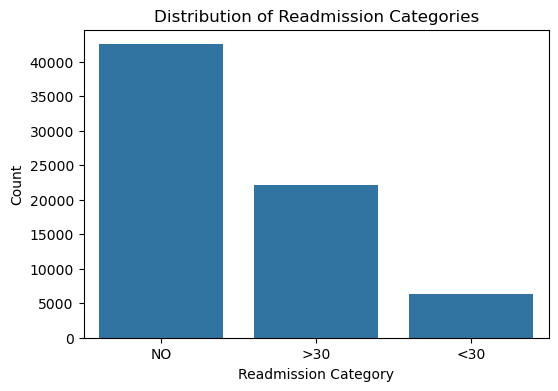

In [23]:
# Plotting the distribution of the target variable
plt.figure(figsize=(6, 4))
sns.countplot(data=df, x='readmitted')
plt.title('Distribution of Readmission Categories')
plt.xlabel('Readmission Category')
plt.ylabel('Count')
plt.show()

#### **Final Cleaning**

For the final stage of cleaning, string variables representing binary categories will be converted into 0s and 1s.

The target column currently contains three different variables: 'NO', '>30', and '<30'. I will replace 'NO' with '0', '>30' with '1', and '<30' with '2'.

Lastly, the range strings in 'age' will be replaced with the mean of the range, and the column will instead be called 'approximate_age'.

In [24]:
# Convert target variable values to 0 or 1
df['readmitted'] = df['readmitted'].replace({'NO': 0, '>30': 1, '<30': 2})
df['gender'] = df['gender'].replace({'Female': 1, 'Male': 0})
df['insulin'] = df['insulin'].replace({'No': 0, 'Steady': 1, 'Down': 1, 'Up': 1})
df['change'] = df['change'].replace({'No': 0, 'Ch': 1})
df['any_diabetes_med'] = df['diabetesMed'].replace({'No': 0, 'Yes': 1})
df = df.drop(columns='diabetesMed')

In [25]:
df['approximate_age'] = df['age'].replace({'[70-80)': 75, '[60-70)': 65, '[50-60)': 55, '[80-90)': 85, '[40-50)': 45, '[30-40)': 40, '[90-100)': 95, '[20-30)': 25})
df = df.drop(columns='age')

In [26]:
df.columns

Index(['gender', 'time_in_hospital', 'num_lab_procedures', 'num_procedures',
       'num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses', 'insulin', 'change',
       'readmitted', 'primary_diagnosis', 'admission_type', 'admission_source',
       'discharge_dispo', 'diabetes_med_change', 'oral_diabetes_med',
       'any_diabetes_med', 'approximate_age'],
      dtype='object')

## 3. EDA

Now that all preliminary cleaning has been completed, a comprehensive exploratory data analysis (EDA) can be conducted.

- First, we'll examine the counts of all variables in each feature.
- Next, we'll review descriptive statistics.
- Lastly, we'll conduct an initial assessment of the relationship between each feature and the target variable, 'readmitted':
    - For numerical columns, we'll calculate Pearson's correlation.
    - For categorical features, we'll perform a chi-squared test and examine the readmission distribution across categories.

In [27]:
numeric_cols = ['time_in_hospital', 'num_lab_procedures', 'num_procedures', 'number_outpatient', 'number_emergency', 'number_inpatient', 'number_diagnoses', 'approximate_age']
categorical_cols = ['primary_diagnosis', 'admission_type', 'admission_source', 'discharge_dispo', 'gender', 'change', 'diabetes_med_change', 'oral_diabetes_med', 'insulin', 'any_diabetes_med']

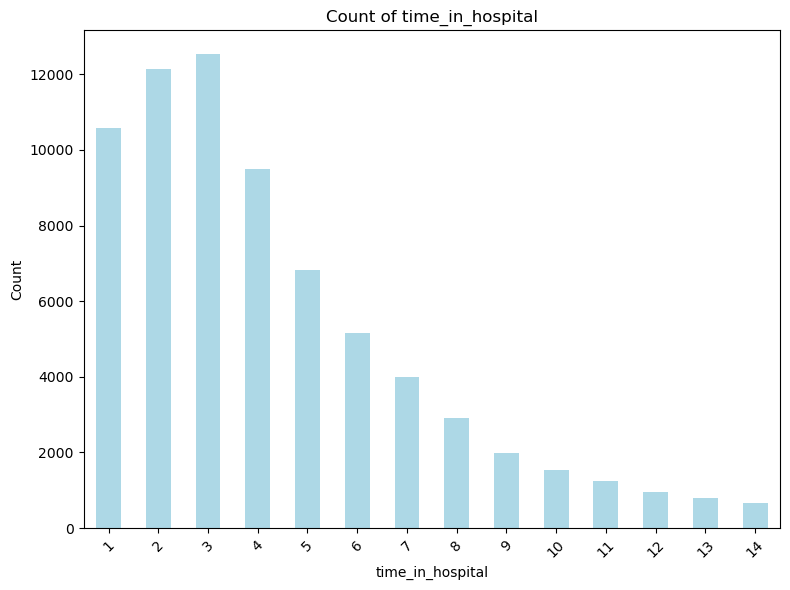

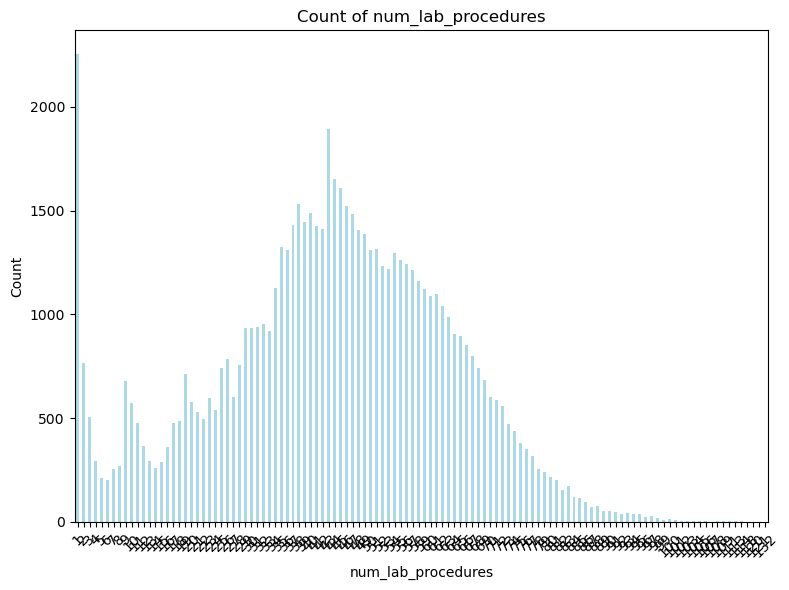

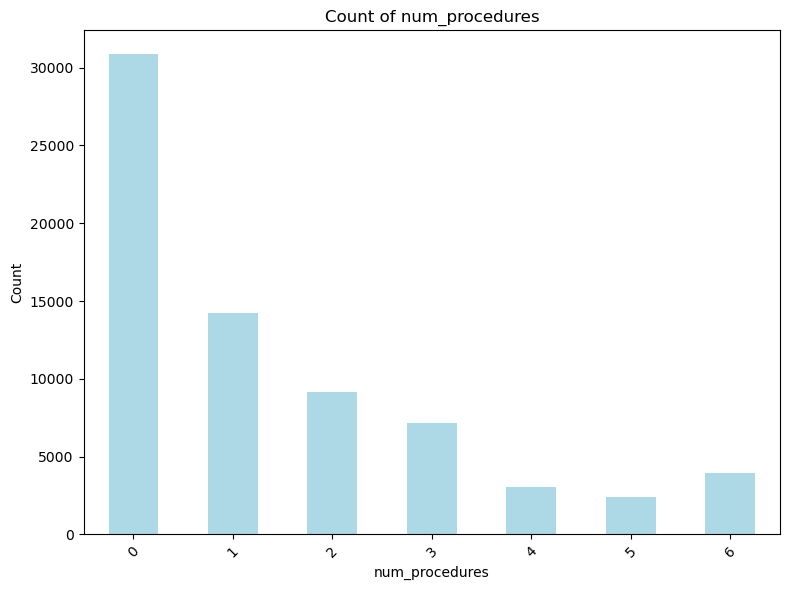

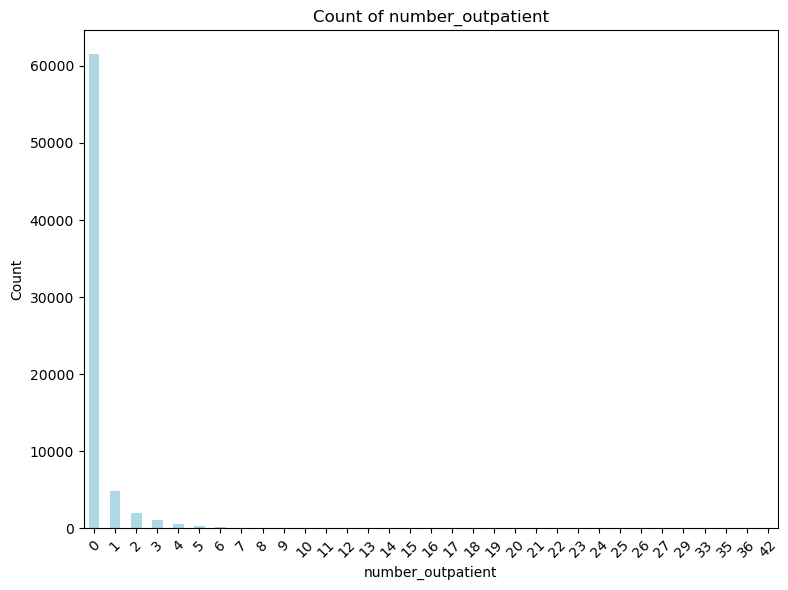

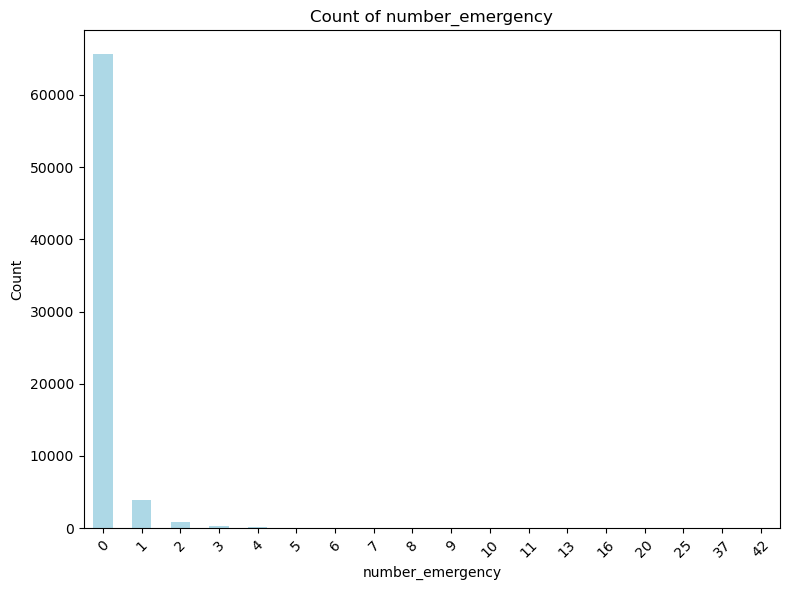

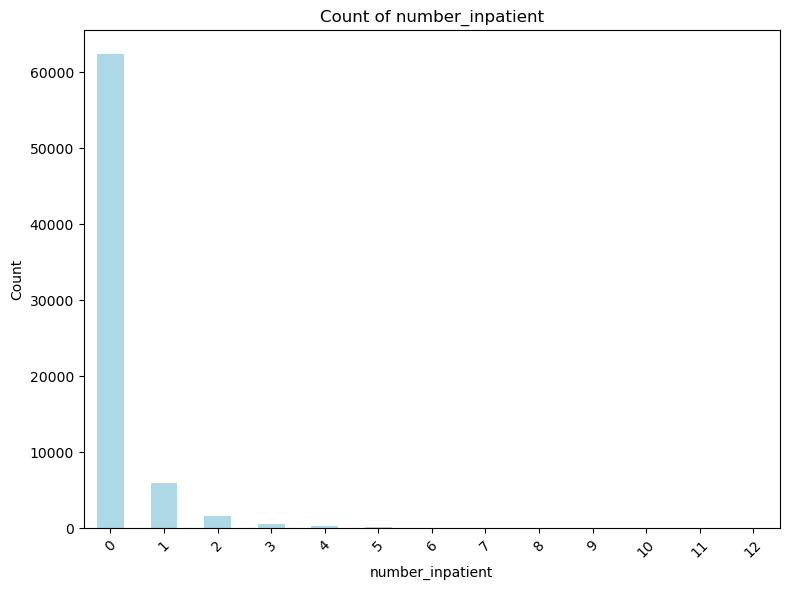

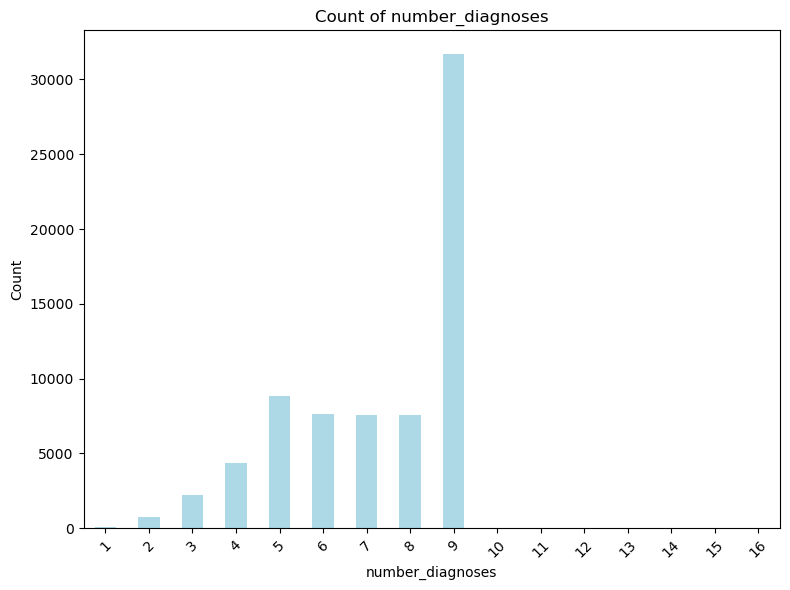

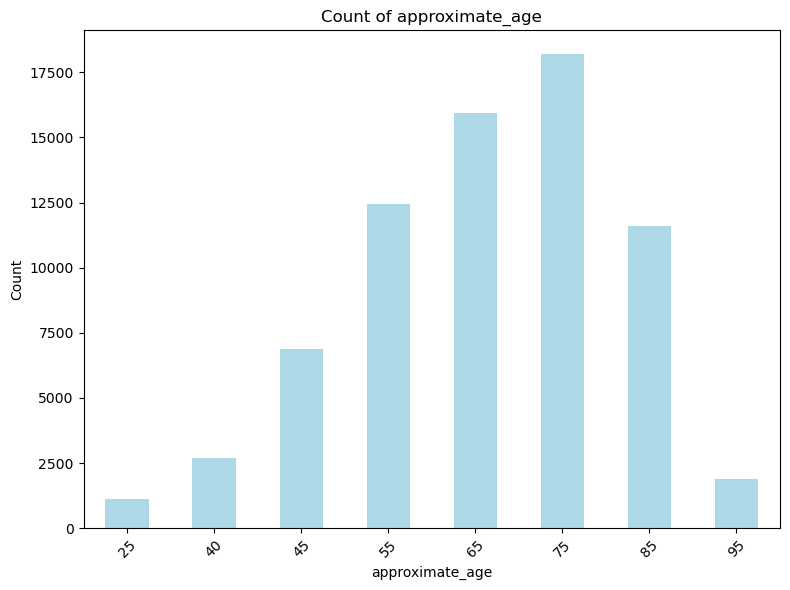

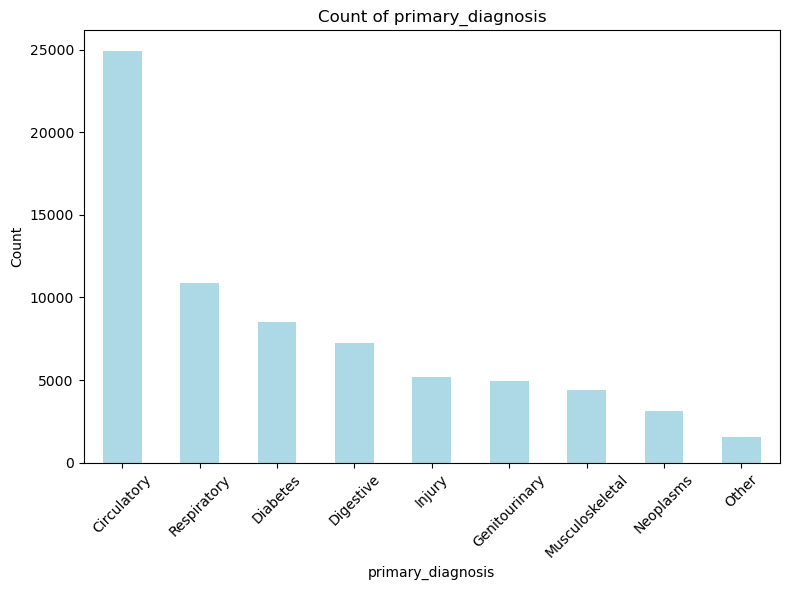

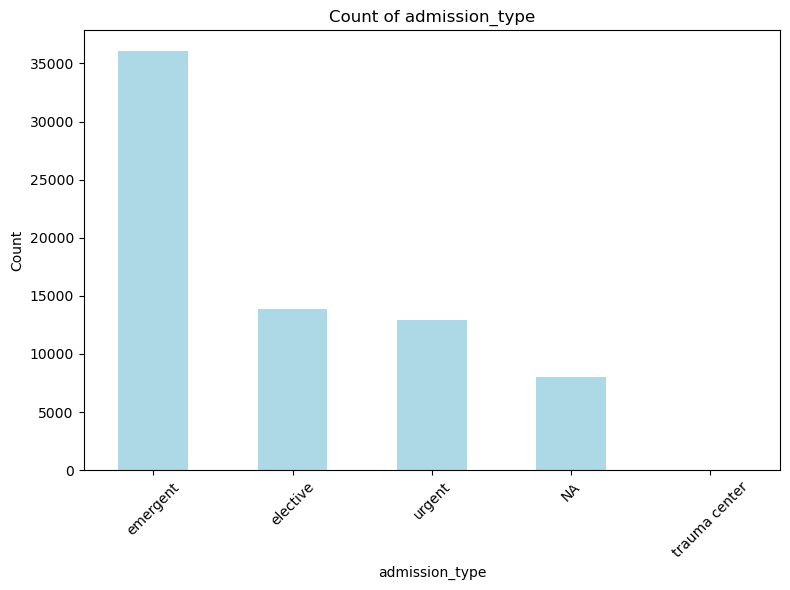

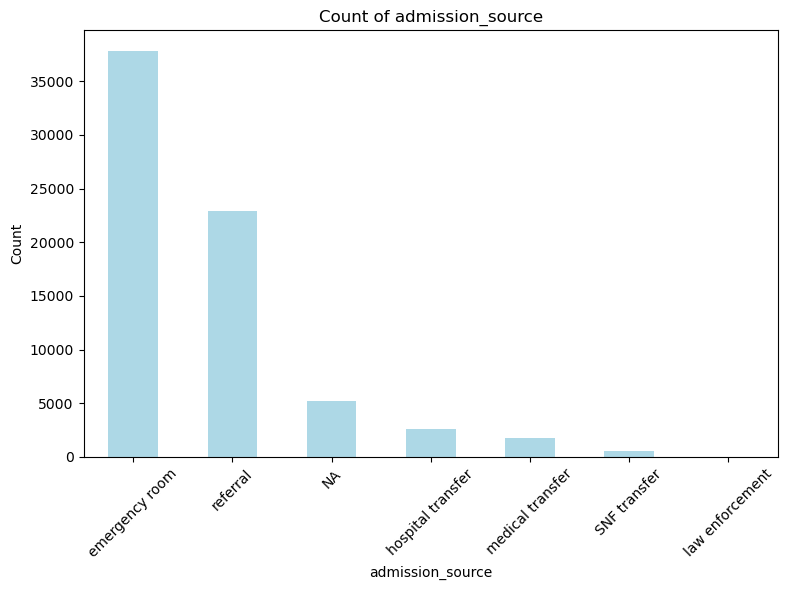

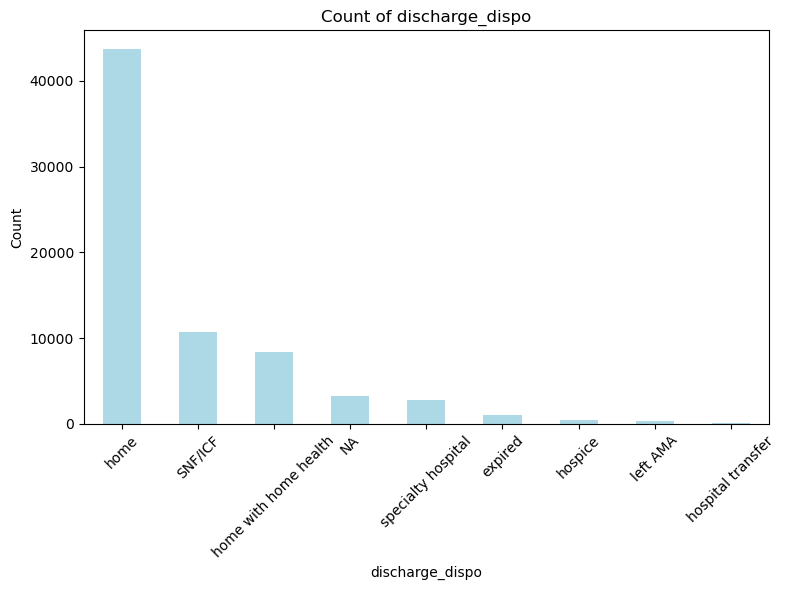

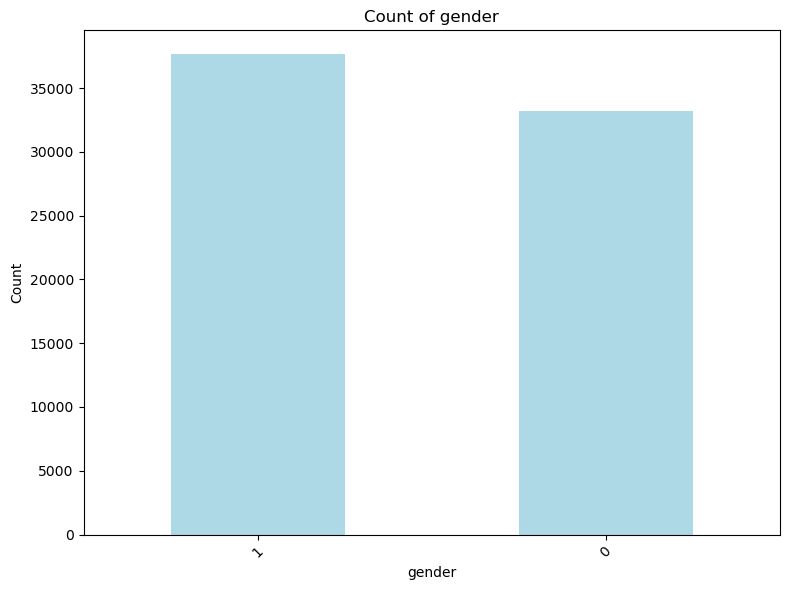

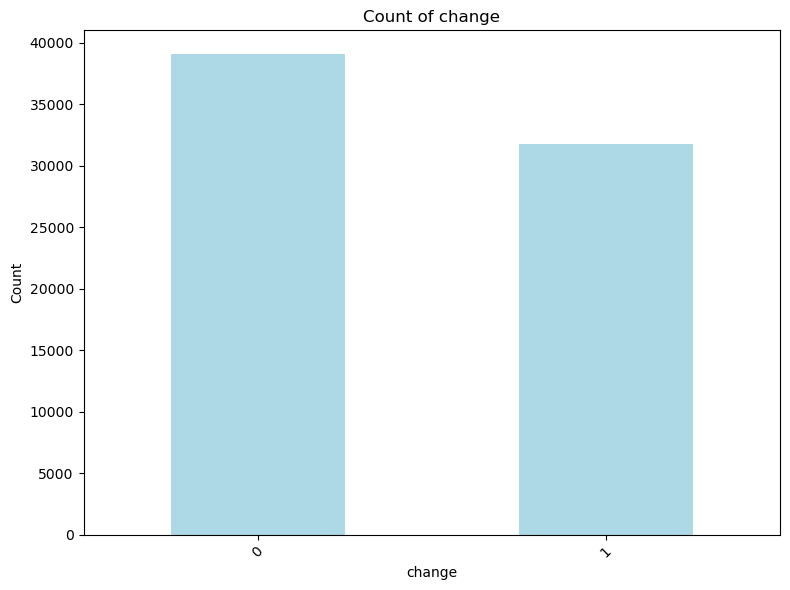

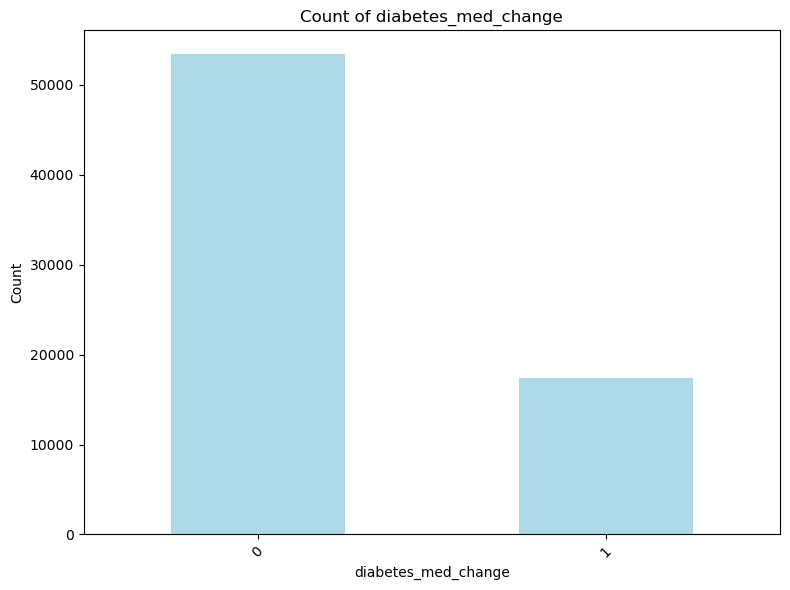

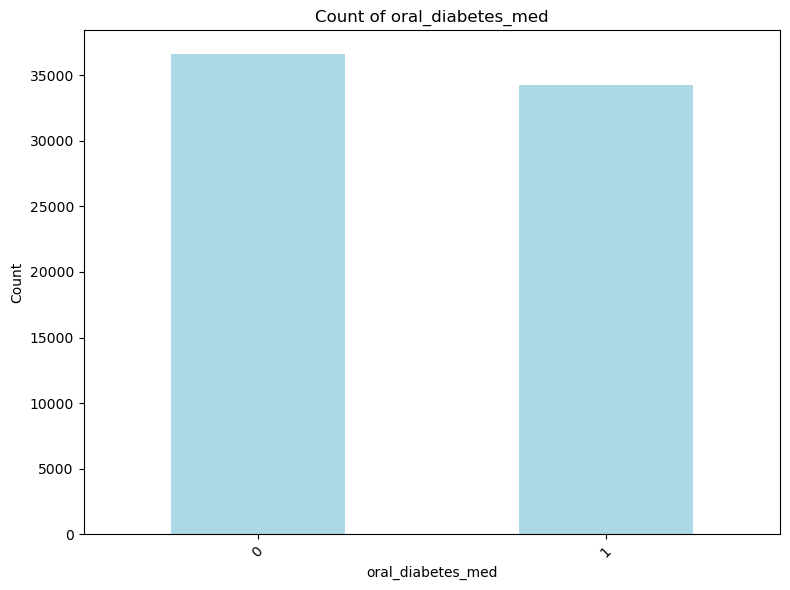

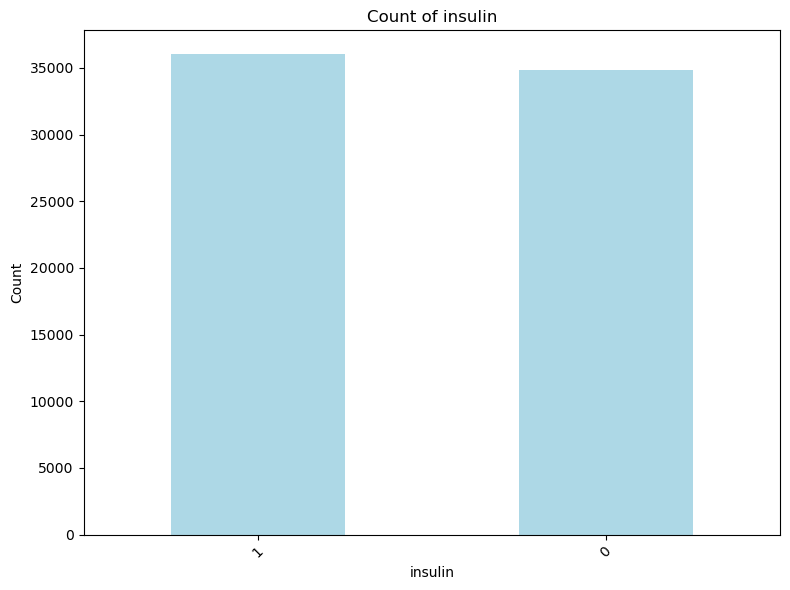

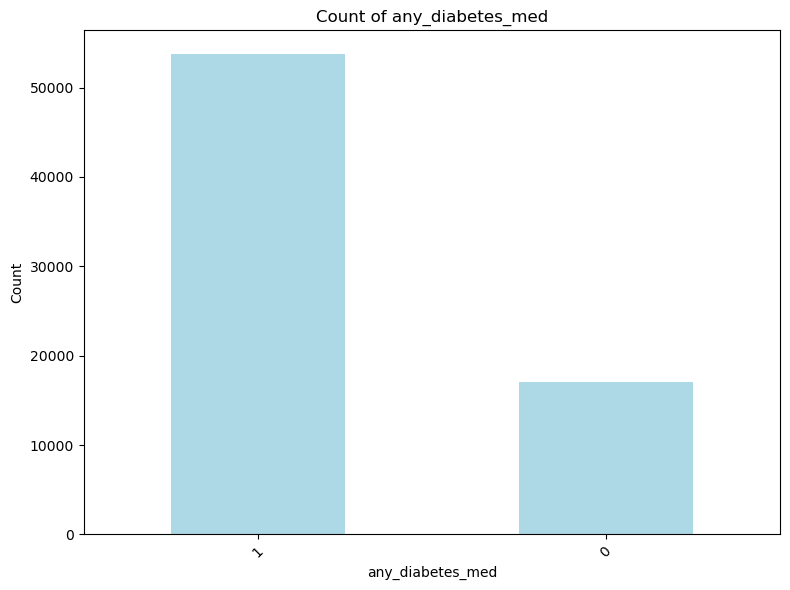

In [28]:
# Plotting for numeric columns
for col in numeric_cols:
    plt.figure(figsize=(8, 6))
    df[col].value_counts().sort_index().plot(kind='bar', color='lightblue')
    plt.title(f'Count of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Plotting for nominal categorical columns
for col in categorical_cols:
    plt.figure(figsize=(8, 6))
    df[col].value_counts().plot(kind='bar', color='lightblue')
    plt.title(f'Count of {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [29]:
df[numeric_cols].describe()

time_in_hospital  num_lab_procedures  num_procedures  \
count      70815.000000        70815.000000    70815.000000   
mean           4.303777           43.087679        1.441460   
std            2.953704           19.945648        1.762813   
min            1.000000            1.000000        0.000000   
25%            2.000000           31.000000        0.000000   
50%            4.000000           44.000000        1.000000   
75%            6.000000           57.000000        2.000000   
max           14.000000          132.000000        6.000000   

       number_outpatient  number_emergency  number_inpatient  \
count       70815.000000      70815.000000      70815.000000   
mean            0.281649          0.103467          0.178352   
std             1.072429          0.508894          0.602892   
min             0.000000          0.000000          0.000000   
25%             0.000000          0.000000          0.000000   
50%             0.000000          0.000000          0.000000   
75%             0.000000          0.000000          0.000000   
max            42.000000         42.000000         12.000000   

       number_diagnoses  approximate_age  
count      70815.000000     70815.000000  
mean           7.281904        66.356704  
std            1.958257        14.804546  
min            1.000000        25.000000  
25%            6.000000        55.000000  
50%            8.000000        65.000000  
75%            9.000000        75.000000  
max           16.000000        95.000000

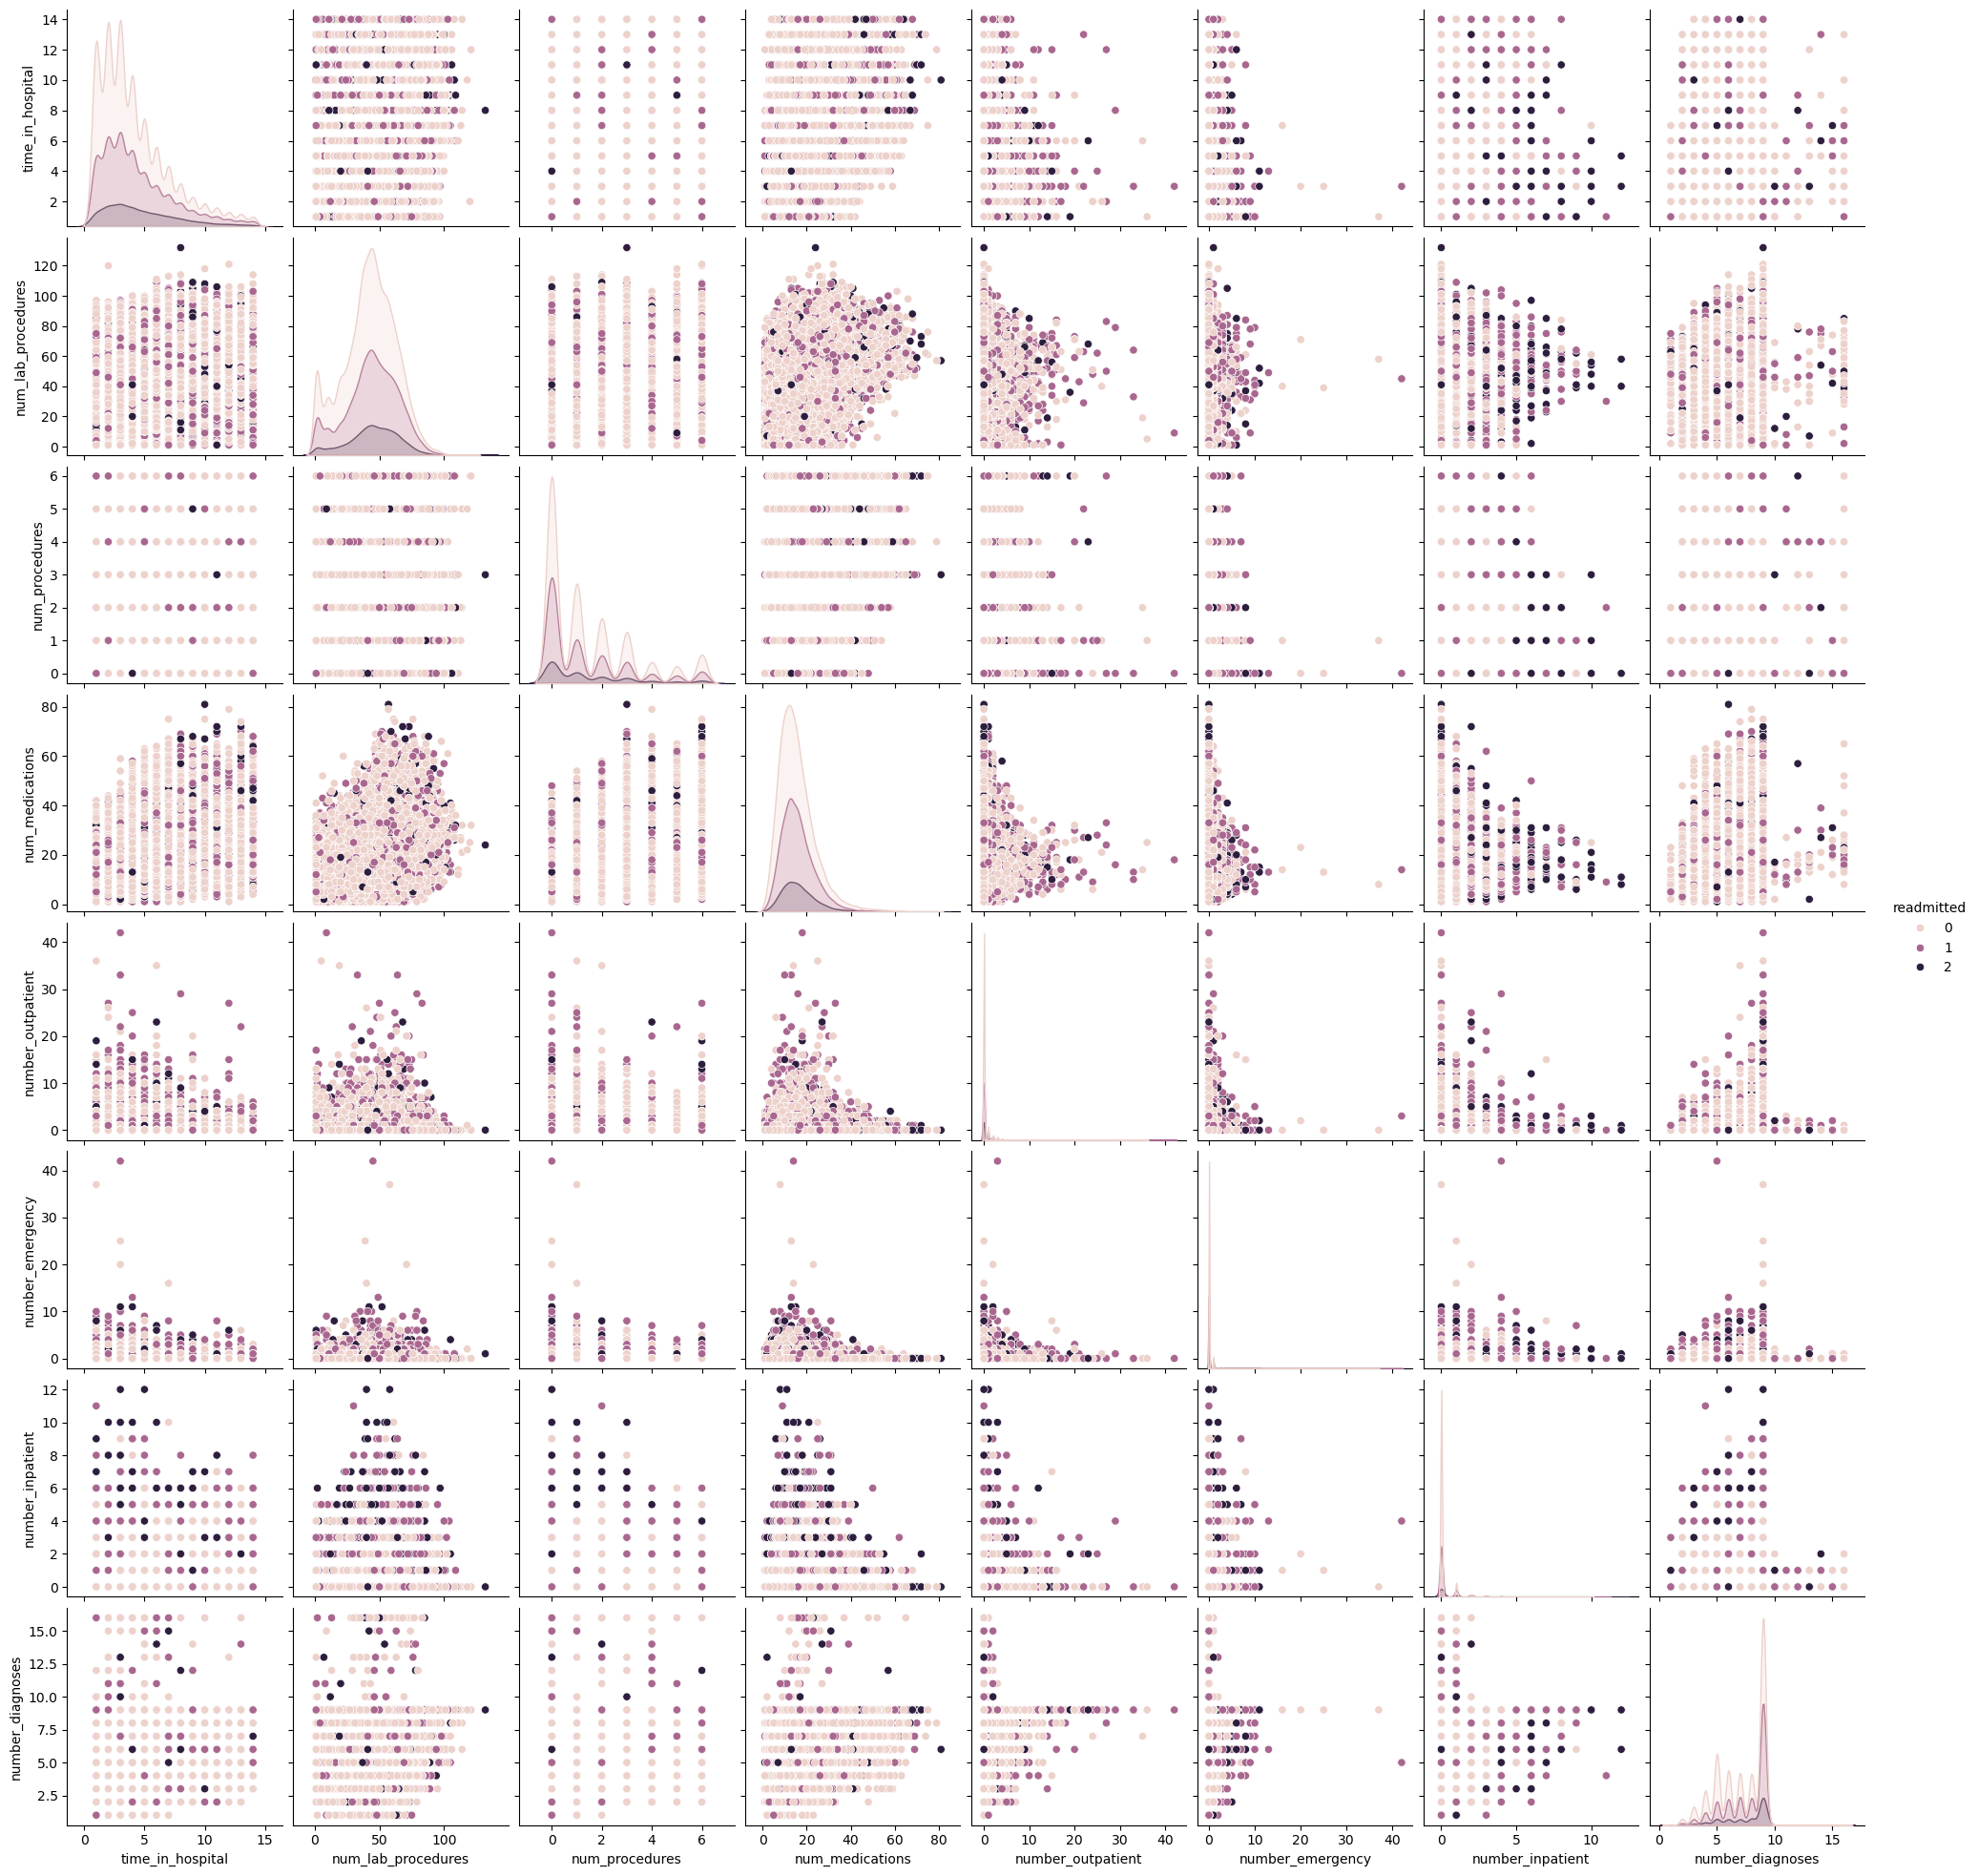

In [30]:
quant_col=df[['readmitted','time_in_hospital', 'num_lab_procedures', 'num_procedures','num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses']]

sns.pairplot(quant_col, hue="readmitted")

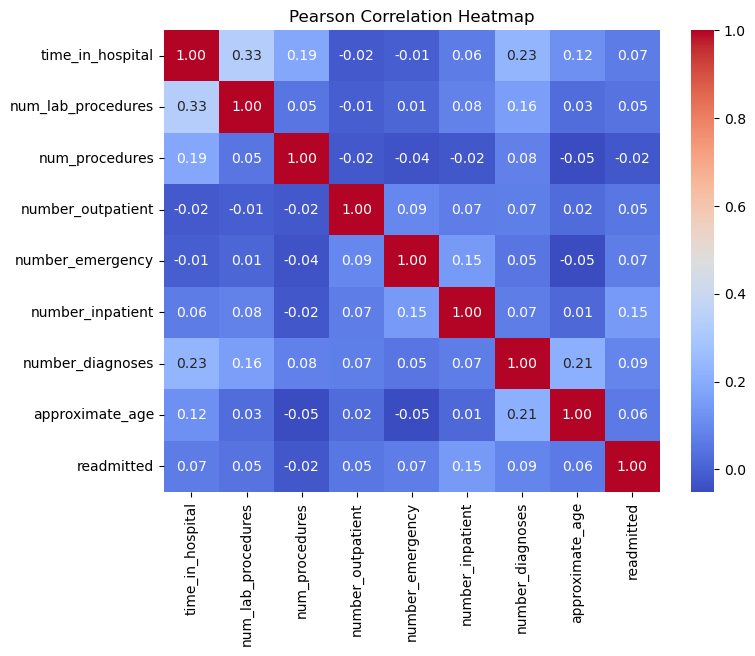

In [31]:
# Calculating Pearson correlation coefficient
correlation_matrix = df[numeric_cols + ['readmitted']].corr()

# Plotting heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pearson Correlation Heatmap')
plt.show()

#### **Correlation Analysis**

None of the numerical features appear to have significant linear relationship with easly readmittance. Knowing this helps narrow down which type of models to consider.


Analyzing relationship between 'primary_diagnosis' and 'readmitted':
Chi-squared test statistic: 290.4086523350914
P-value: 2.4620104957314192e-52


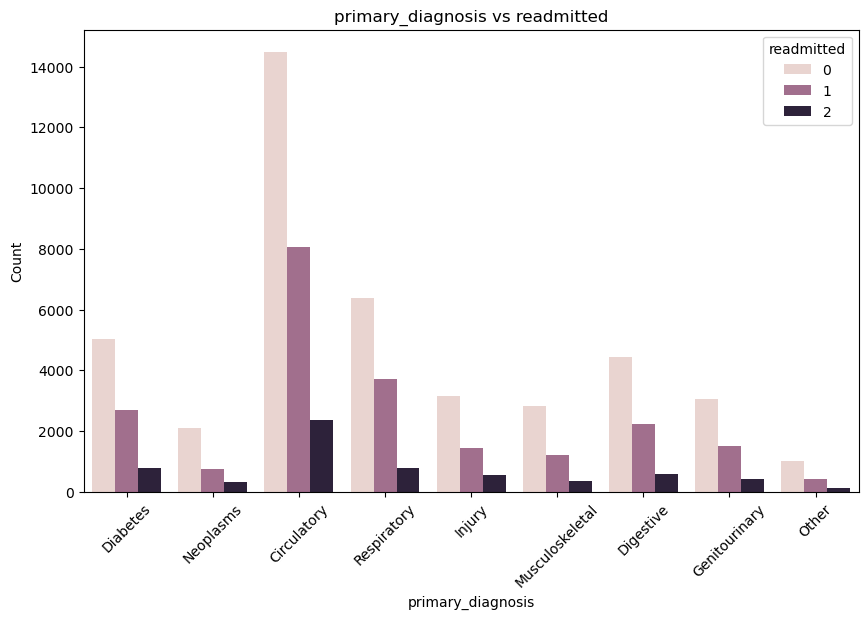


Analyzing relationship between 'admission_type' and 'readmitted':
Chi-squared test statistic: 306.8275104725305
P-value: 1.4494866917702759e-61


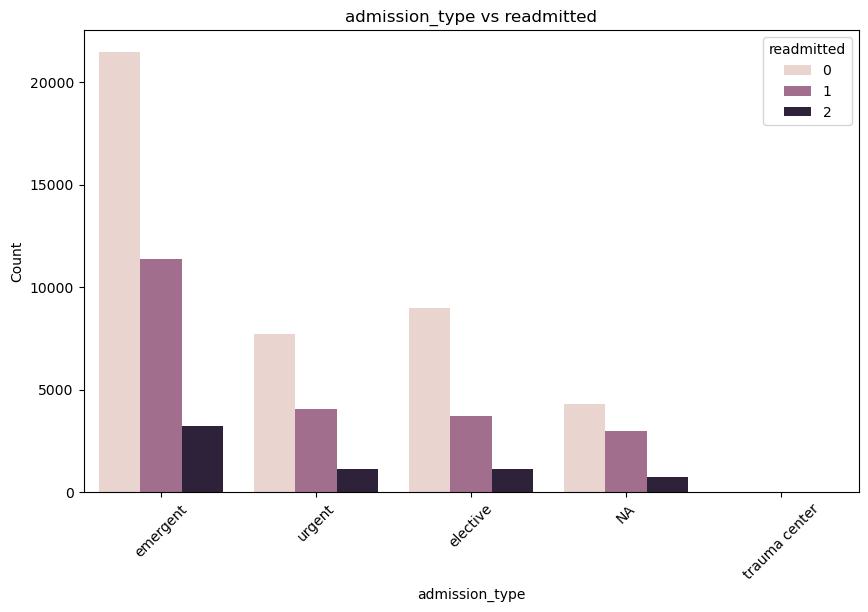


Analyzing relationship between 'admission_source' and 'readmitted':
Chi-squared test statistic: 553.1185534945213
P-value: 1.0702530107795851e-110


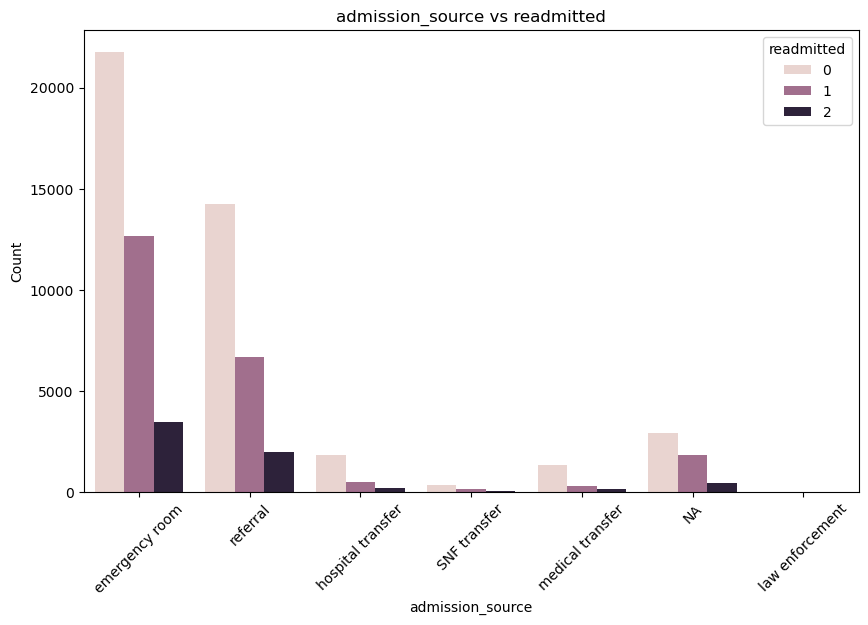


Analyzing relationship between 'discharge_dispo' and 'readmitted':
Chi-squared test statistic: 2067.5845558537394
P-value: 0.0


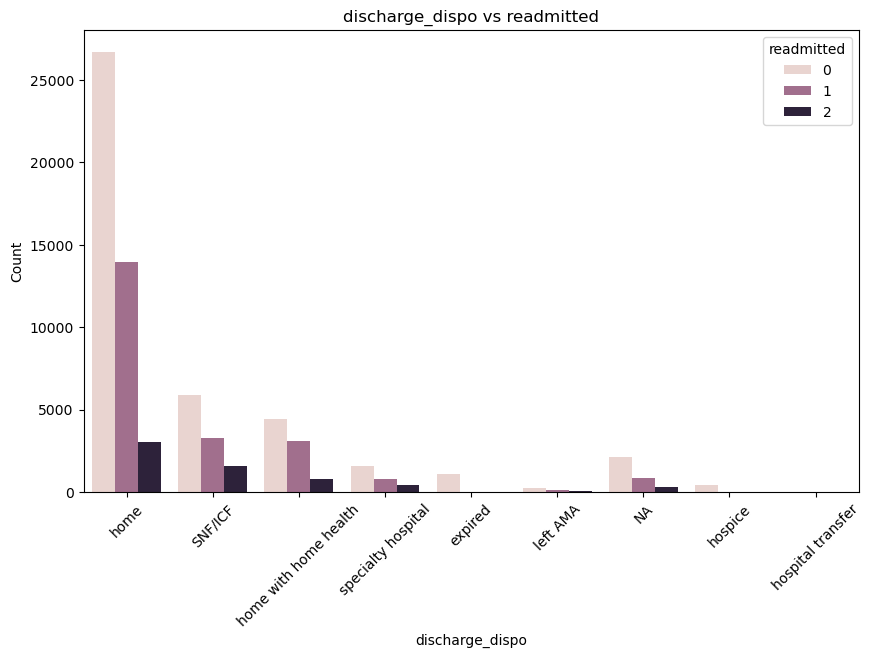


Analyzing relationship between 'gender' and 'readmitted':
Chi-squared test statistic: 19.26708486618252
P-value: 6.549462805648388e-05


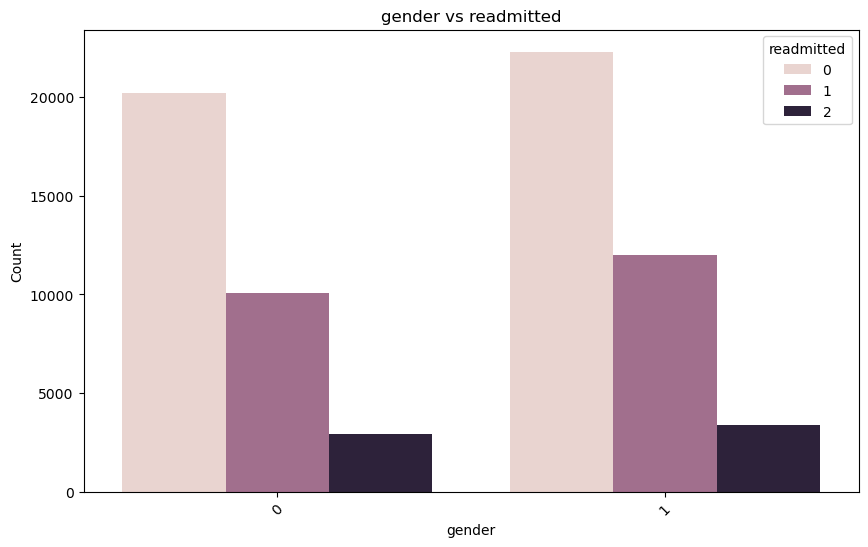


Analyzing relationship between 'change' and 'readmitted':
Chi-squared test statistic: 103.79932837728568
P-value: 2.88577342865478e-23


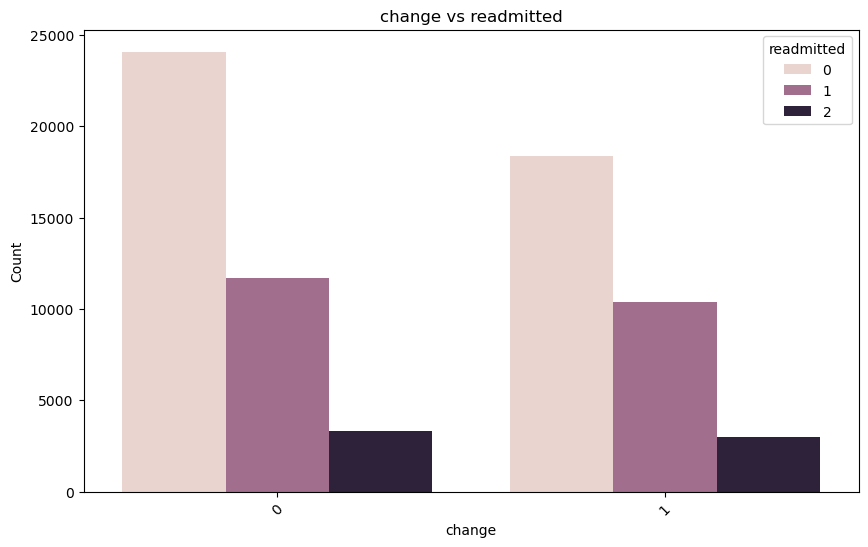


Analyzing relationship between 'diabetes_med_change' and 'readmitted':
Chi-squared test statistic: 121.56430370309532
P-value: 4.0054088463457775e-27


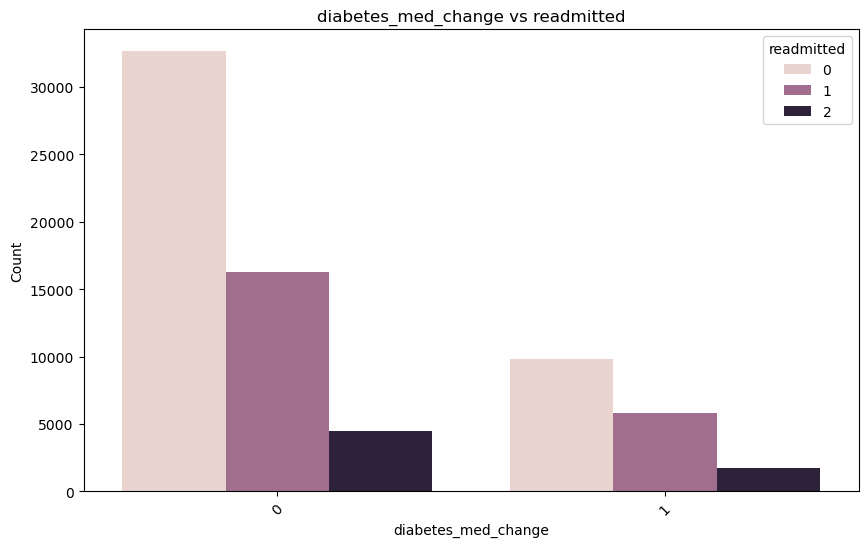


Analyzing relationship between 'oral_diabetes_med' and 'readmitted':
Chi-squared test statistic: 84.58258119608881
P-value: 4.296609265987289e-19


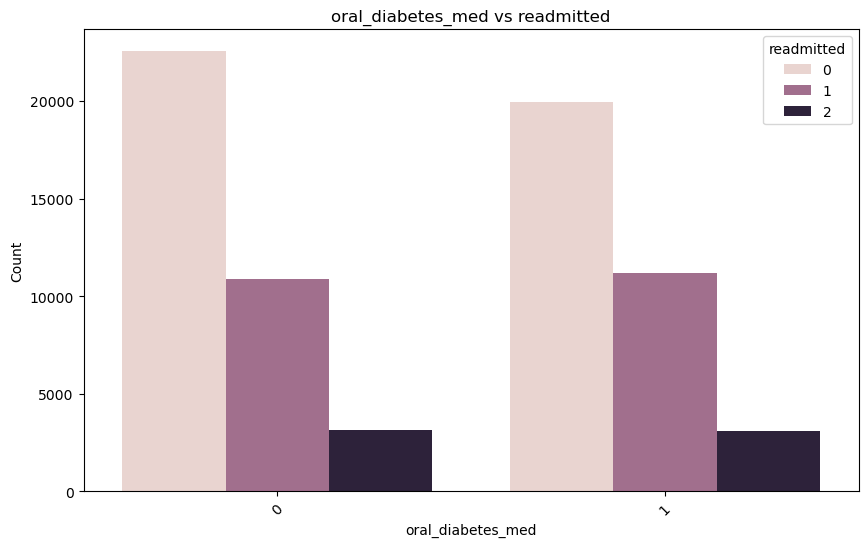


Analyzing relationship between 'insulin' and 'readmitted':
Chi-squared test statistic: 89.7665585859428
P-value: 3.216914167250552e-20


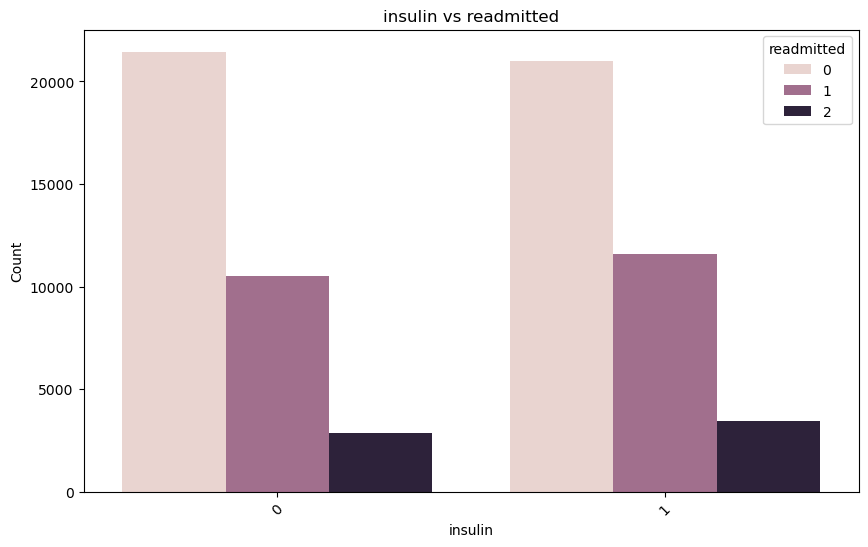


Analyzing relationship between 'any_diabetes_med' and 'readmitted':
Chi-squared test statistic: 293.67433131045067
P-value: 1.696013159355552e-64


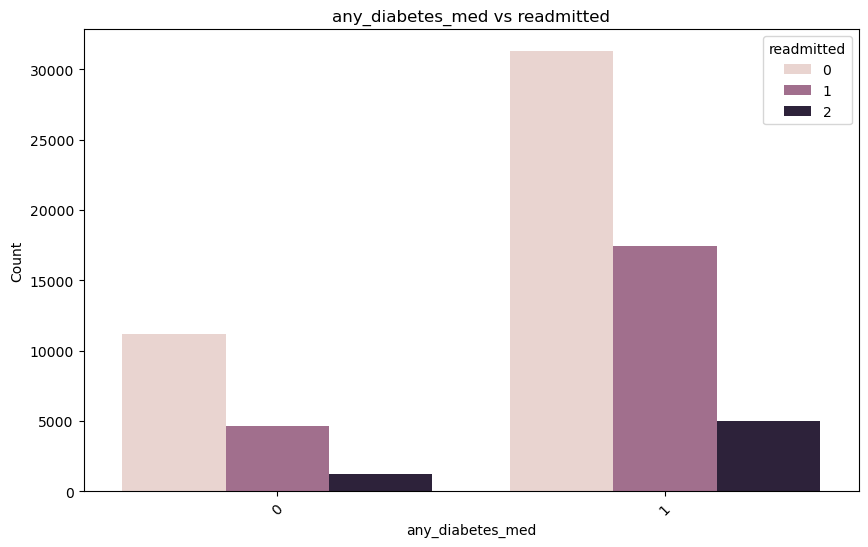

In [32]:
from scipy.stats import chi2_contingency


# Function to calculate chi-squared test and plot count plot
def chi_squared_and_plot(df, cat_col, target_col):
    # Crosstab to get frequencies
    contingency_table = pd.crosstab(df[cat_col], df[target_col])
    
    # Chi-squared test
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    print(f"Chi-squared test statistic: {chi2}")
    print(f"P-value: {p}")

    # Plot count plot
    plt.figure(figsize=(10, 6))
    sns.countplot(data=df, x=cat_col, hue=target_col)
    plt.title(f'{cat_col} vs {target_col}')
    plt.xlabel(cat_col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.legend(title=target_col)
    plt.show()

# Iterate over categorical columns
for col in categorical_cols:
    print(f"\nAnalyzing relationship between '{col}' and 'readmitted':")
    chi_squared_and_plot(df, col, 'readmitted')

#### **Chi-Squared Analysis**

Here is the break down of the chi-squared results, considering that:
1. The null hypothesis in each instance is that each feature has ***no*** relationship with readmission.
2. The alpha value is 0.05.
Based on the provided results of chi-squared tests for each feature's relationship with readmission, here is the interpretation:

**Primary Diagnosis and Readmission:**

- Chi-squared test statistic: 290.41
- P-value: 2.46e-52
- Interpretation: The relationship between the primary diagnosis and readmission is statistically significant (p < 0.05). Therefore, we reject the null hypothesis that there is no relationship between primary diagnosis and readmission.

**Admission Type and Readmission:**

- Chi-squared test statistic: 306.83
- P-value: 1.45e-61
- Interpretation: The relationship between admission type and readmission is statistically significant (p < 0.05). Therefore, we reject the null hypothesis that there is no relationship between admission type and readmission.

**Admission Source and Readmission:**

- Chi-squared test statistic: 553.12
- P-value: 1.07e-110
- Interpretation: The relationship between admission source and readmission is statistically significant (p < 0.05). Therefore, we reject the null hypothesis that there is no relationship between admission source and readmission.

**Discharge Disposition and Readmission:**

- Chi-squared test statistic: 2067.58
- P-value: 0.0
- Interpretation: The relationship between discharge disposition and readmission is statistically significant (p < 0.05). Therefore, we reject the null hypothesis that there is no relationship between discharge disposition and readmission.

**Gender and Readmission:**

- Chi-squared test statistic: 19.27
- P-value: 6.55e-05
- Interpretation: The relationship between gender and readmission is statistically significant (p < 0.05). Therefore, we reject the null hypothesis that there is no relationship between gender and readmission.

**Change and Readmission:**

- Chi-squared test statistic: 103.80
- P-value: 2.89e-23
- Interpretation: The relationship between change and readmission is statistically significant (p < 0.05). Therefore, we reject the null hypothesis that there is no relationship between change and readmission.

**Diabetes Medication Change and Readmission:**

- Chi-squared test statistic: 121.56
- P-value: 4.01e-27
- Interpretation: The relationship between diabetes medication change and readmission is statistically significant (p < 0.05). Therefore, we reject the null hypothesis that there is no relationship between diabetes medication change and readmission.

**Oral Diabetes Medication and Readmission:**

- Chi-squared test statistic: 84.58
- P-value: 4.30e-19
- Interpretation: The relationship between oral diabetes medication and readmission is statistically significant (p < 0.05). Therefore, we reject the null hypothesis that there is no relationship between oral diabetes medication and readmission.

**Insulin and Readmission:**

Chi-squared test statistic: 89.77
- P-value: 3.22e-20
- Interpretation: The relationship between insulin and readmission is statistically significant (p < 0.05). Therefore, we reject the null - hypothesis that there is no relationship between insulin and readmission.

**Any Diabetes Medication and Readmission:**

- Chi-squared test statistic: 293.67
- P-value: 1.70e-64
- Interpretation: The relationship between any diabetes medication and readmission is statistically significant (p < 0.05). Therefore, we reject the null hypothesis that there is no relationship between any diabetes medication and readmission.

#### **Summary**

1. All categories seem to have a significant relationship with readmission.

2. Discharge disposition has the strongest relationship with readmission, suggesting that it will be an important feature for modeling.

In [33]:
X = df.drop(columns='readmitted')
y = df['readmitted']

# Splitting the dataset into training and testing sets while stratifying by the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# Calculate the size for the validation set to be 10% of the entire dataset
val_size = 0.1 / 0.9  # 10% of the whole dataset

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, stratify=y_train, random_state=42)

## 5. Pre-Processing

Pre-processing steps will involve scaling the numerical data and encoding the categorical data.

The final pre-processing step will address the class imbalance in the target variable. While 0 is overwhelmingly over-represented, the primary goal is to accurately categorize instances of 1. To address this issue, SMOTE will be utilized.

In [34]:
from imblearn.under_sampling import RandomUnderSampler
# Instantiate pipeline transformers
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder())
])

# Combine transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Preprocessing pipeline
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])

# Fit and transform the training data
X_train_transformed = preprocessor.fit_transform(X_train)

# Retrieve the column names after one-hot encoding
encoded_columns = preprocessor.named_transformers_['cat'].named_steps['onehot'].get_feature_names_out(input_features=categorical_cols)

# Define the function to convert numpy array to DataFrame
def convert_to_dataframe(X, columns):
    return pd.DataFrame(X, columns=np.concatenate([numeric_cols, encoded_columns]))

# Create the FunctionTransformer instance
to_dataframe = FunctionTransformer(func=convert_to_dataframe, kw_args={'columns': np.concatenate([numeric_cols, encoded_columns])})

# Combine preprocessing and DataFrame conversion steps
preprocess_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessor),
    ('to_dataframe', to_dataframe)
])

# Fit and transform the training data
X_train = preprocess_pipeline.fit_transform(X_train)


# Create an instance of the RandomUnderSampler
#undersampler = RandomUnderSampler(sampling_strategy='majority')

# Perform undersampling on X_train and y_train
#X_train, y_train = undersampler.fit_resample(X_train, y_train)

X_train

time_in_hospital  num_lab_procedures  num_procedures  \
0              0.912043            0.194140        0.884814   
1             -1.117728            0.144067        0.884814   
2             -0.779432            0.544648       -0.817918   
3              0.235453            1.095448       -0.817918   
4              0.573748            0.544648        0.317237   
...                 ...                 ...             ...   
56646         -0.441137           -0.807314        0.884814   
56647         -0.441137            0.945230       -0.817918   
56648         -0.102842            0.394430        0.317237   
56649         -0.779432            0.444503       -0.817918   
56650         -0.779432           -1.658549       -0.817918   

       number_outpatient  number_emergency  number_inpatient  \
0              -0.259791         -0.199281         -0.294780   
1              -0.259791         -0.199281         -0.294780   
2              -0.259791         -0.199281         -0.294780   
3              -0.259791         -0.199281          2.995458   
4               1.598704         -0.199281         -0.294780   
...                  ...               ...               ...   
56646          -0.259791         -0.199281         -0.294780   
56647          -0.259791         -0.199281         -0.294780   
56648          -0.259791         -0.199281         -0.294780   
56649          -0.259791         -0.199281         -0.294780   
56650          -0.259791         -0.199281          1.350339   

       number_diagnoses  approximate_age  primary_diagnosis_Circulatory  \
0              0.880212        -0.767825                            0.0   
1              0.880212         0.584054                            1.0   
2             -1.162887        -2.795642                            0.0   
3              0.880212         0.584054                            1.0   
4              0.880212         1.935932                            0.0   
...                 ...              ...                            ...   
56646         -1.673662        -0.767825                            1.0   
56647          0.880212         0.584054                            0.0   
56648         -2.184437         0.584054                            0.0   
56649         -1.673662        -1.781733                            0.0   
56650         -2.184437        -0.767825                            0.0   

       primary_diagnosis_Diabetes  ...  change_0  change_1  \
0                             0.0  ...       1.0       0.0   
1                             0.0  ...       1.0       0.0   
2                             1.0  ...       1.0       0.0   
3                             0.0  ...       1.0       0.0   
4                             0.0  ...       1.0       0.0   
...                           ...  ...       ...       ...   
56646                         0.0  ...       1.0       0.0   
56647                         0.0  ...       1.0       0.0   
56648                         0.0  ...       1.0       0.0   
56649                         1.0  ...       0.0       1.0   
56650                         0.0  ...       1.0       0.0   

       diabetes_med_change_0  diabetes_med_change_1  oral_diabetes_med_0  \
0                        1.0                    0.0                  1.0   
1                        1.0                    0.0                  1.0   
2                        1.0                    0.0                  1.0   
3                        1.0                    0.0                  1.0   
4                        1.0                    0.0                  1.0   
...                      ...                    ...                  ...   
56646                    1.0                    0.0                  0.0   
56647                    1.0                    0.0                  1.0   
56648                    1.0                    0.0                  1.0   
56649                    1.0                    0.0                  0.0   

In [35]:
len(y_val)

7082

## 6. Principal Component Analysis

Even after consolidating diabetes medications and dropping irrelevant features, after encoding there are still 50 features.

Before modeling, a principal component analysis (PCA) will be conducted to optimise the amount of features used.

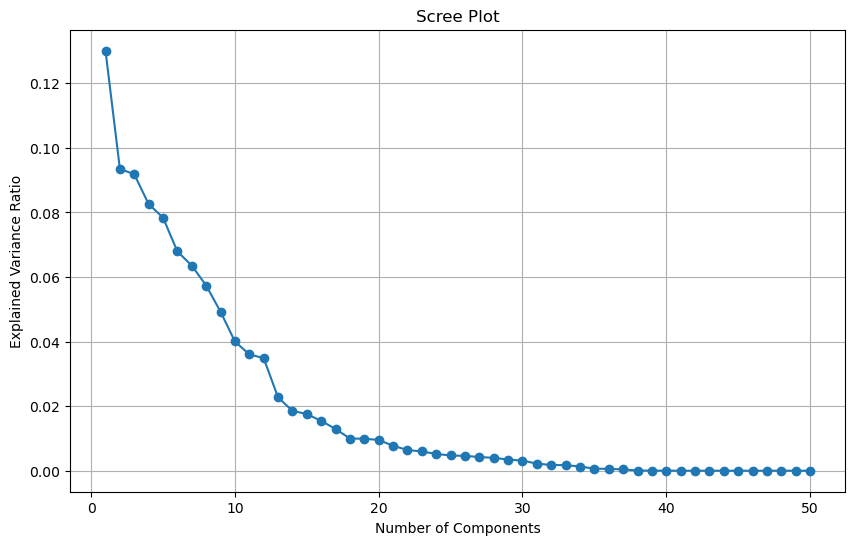

In [36]:
# Initialize PCA with all components
pca = PCA()

# Fit PCA on the training data
pca.fit(X_train)

# Plot the explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Scree Plot')
plt.grid(True)
plt.show()

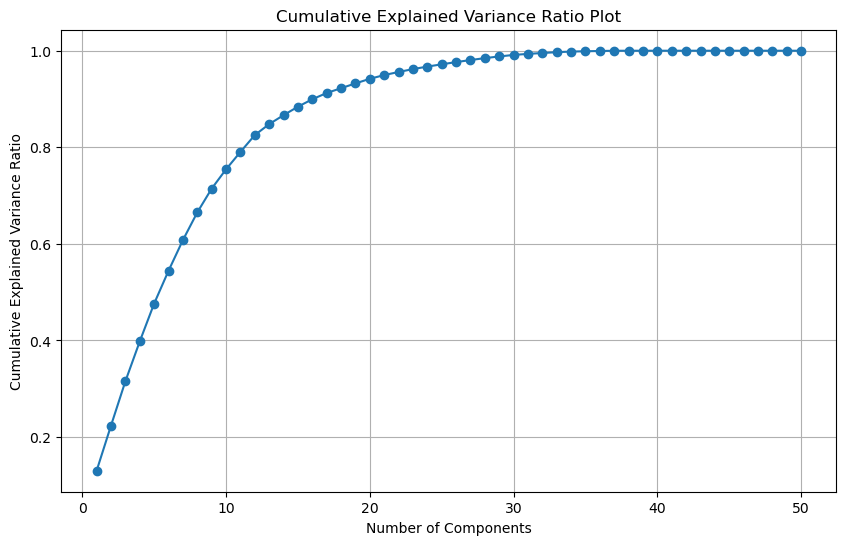

In [37]:
# Calculate cumulative explained variance ratio
cumulative_variance_ratio = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance ratio
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance_ratio) + 1), cumulative_variance_ratio, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Cumulative Explained Variance Ratio Plot')
plt.grid(True)
plt.show()

#### **PCA Analyis**

According the the visuals, 12-14 features seems to be the optimal amount of components to use.

# II. Modeling with a Non-binary target

## 1. Initial Modeling Attempt

In my initial attempts with this project, I experimented with transforming the target variable into a binary format, where '0' represented both 'No' and '>30', while '1' represented '<30'. Despite several attempts to address class imbalance, I struggled to obtain a model that outperformed random guessing. In an effort to improve classification accuracy, I decided to retain the three distinct values of the target variable, allowing models to distinguish '<30' separately.

Moving forward, I will revisit transforming the target variable into a binary format and exploring classification models under this framework.

During this phase, I tested various classification models, including Naive Bayes, K Nearest Neighbors, Support Vector Classifier (SVC), Random Forest, and Gradient Boosting Classifier, to identify the most effective approach.

In [38]:
X_val = preprocess_pipeline.transform(X_val)

In [39]:
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [40]:
#Naive Bayes
nbm = GaussianNB()
nbm.fit(X_train,y_train)
nbm_pred = nbm.predict(X_val)

#KNN
knn = KNeighborsClassifier() 
knn.fit(X_train,y_train)
knn_pred = knn.predict(X_val)

#SVM
svm = SVC() 
svm.fit(X_train,y_train)
svm_pred = svm.predict(X_val)

#Randon Forest
rfm = RandomForestClassifier() 
rfm.fit(X_train,y_train)
rfm_pred = rfm.predict(X_val)

#Gradient Boosting
gbm = GradientBoostingClassifier() 
gbm.fit(X_train,y_train)
gbm_pred = gbm.predict(X_val)

In [41]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Define the classifiers
classifiers = {
    'Naive Bayes': nbm,
    'KNN': knn,
    'SVM': svm,
    'Random Forest': rfm,
    'Gradient Boosting': gbm
}

# Define the predictions
predictions = {
    'Naive Bayes': nbm_pred,
    'KNN': knn_pred,
    'SVM': svm_pred,
    'Random Forest': rfm_pred,
    'Gradient Boosting': gbm_pred
}

# Define the evaluation metrics
metrics = {
    'Accuracy': accuracy_score,
    'Precision': precision_score,
    'Recall': recall_score,
    'F1 Score': f1_score
}

# Loop over classifiers and evaluate each with different metrics
for clf_name, clf in classifiers.items():
    print(f"Evaluation metrics for {clf_name}:")
    for metric_name, metric_func in metrics.items():
        if metric_name != 'Accuracy':
            score = metric_func(y_val, predictions[clf_name], average='macro')
        else:
            score = metric_func(y_val, predictions[clf_name])
        print(f"{metric_name}: {score:.4f}")
    print("-----------------------")

Evaluation metrics for Naive Bayes:
Accuracy: 0.3159
Precision: 0.4631
Recall: 0.3673
F1 Score: 0.2316
-----------------------
Evaluation metrics for KNN:
Accuracy: 0.5764
Precision: 0.3944
Recall: 0.3685
F1 Score: 0.3547
-----------------------
Evaluation metrics for SVM:
Accuracy: 0.6127
Precision: 0.3733
Recall: 0.3614
F1 Score: 0.3204
-----------------------
Evaluation metrics for Random Forest:
Accuracy: 0.5964
Precision: 0.4117
Recall: 0.3777
F1 Score: 0.3624
-----------------------
Evaluation metrics for Gradient Boosting:
Accuracy: 0.6156
Precision: 0.4530
Recall: 0.3685
F1 Score: 0.3342
-----------------------


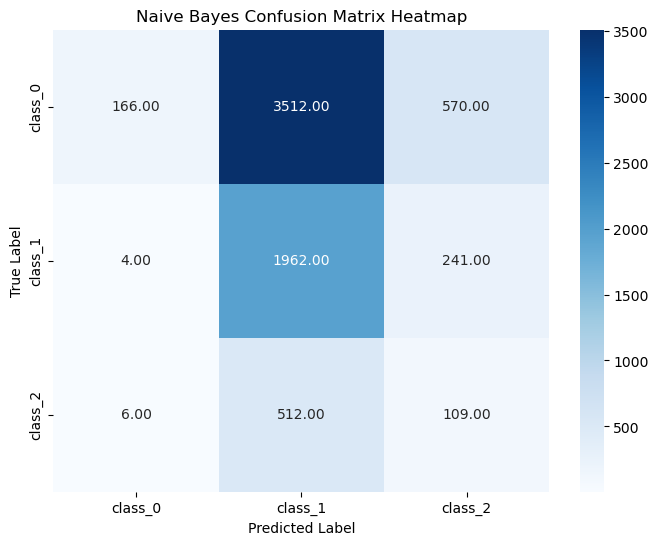

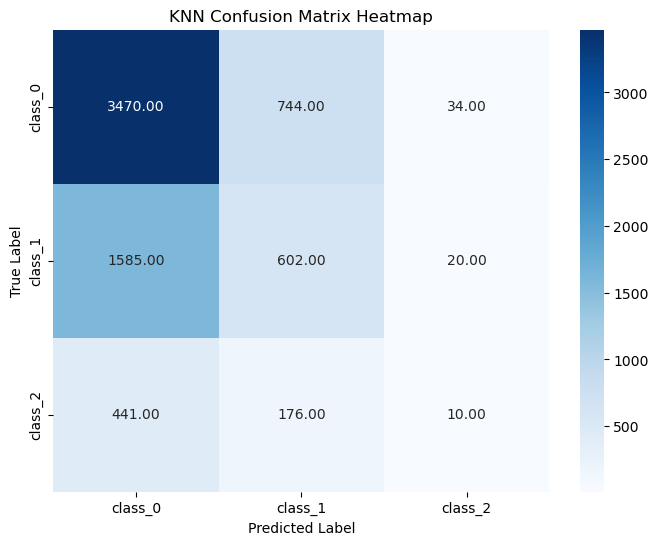

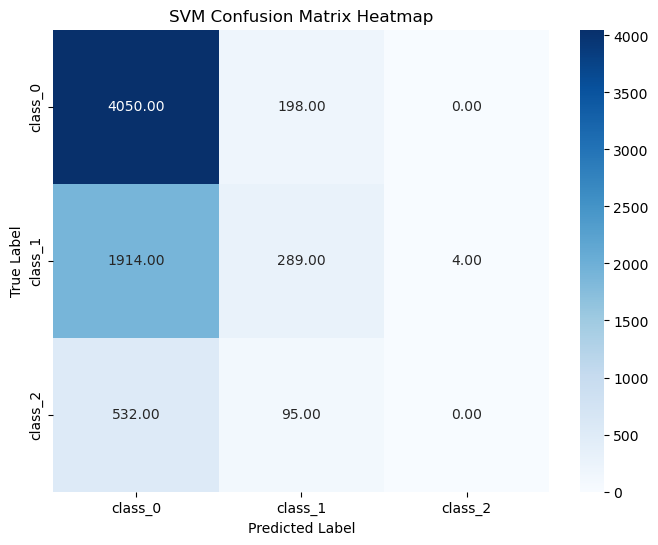

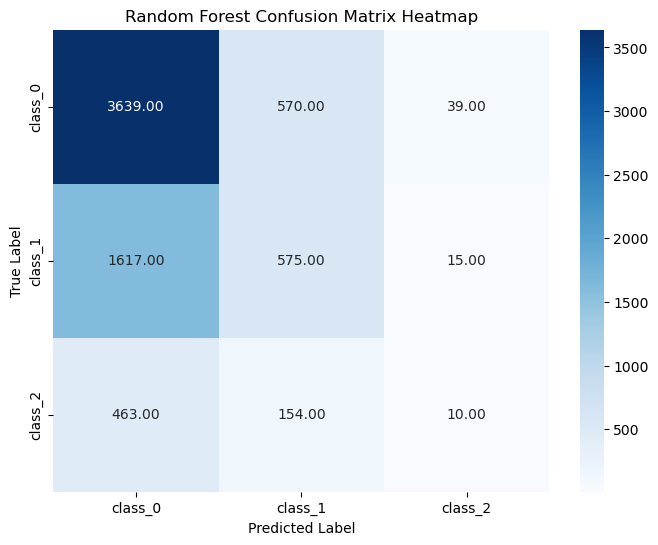

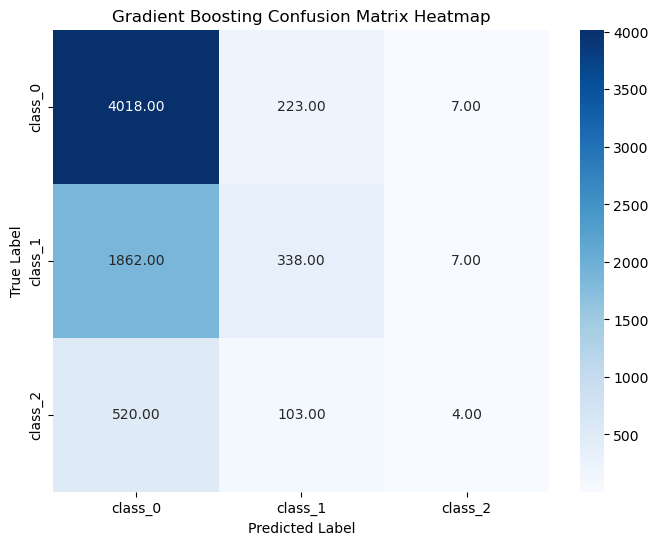

In [42]:
# Define the function to plot confusion matrix heatmap
def plot_confusion_matrix_heatmap(y_true, y_pred, classes, normalize=False, title=None, cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt=".2f", cmap=cmap, xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix' if title is None else title)
    plt.show()

# Now, after making predictions with each classifier, call the function to plot confusion matrix heatmap
plot_confusion_matrix_heatmap(y_val, nbm_pred, classes=['class_0', 'class_1', 'class_2'], title='Naive Bayes Confusion Matrix Heatmap')
plot_confusion_matrix_heatmap(y_val, knn_pred, classes=['class_0', 'class_1', 'class_2'], title='KNN Confusion Matrix Heatmap')
plot_confusion_matrix_heatmap(y_val, svm_pred, classes=['class_0', 'class_1', 'class_2'], title='SVM Confusion Matrix Heatmap')
plot_confusion_matrix_heatmap(y_val, rfm_pred, classes=['class_0', 'class_1', 'class_2'], title='Random Forest Confusion Matrix Heatmap')
plot_confusion_matrix_heatmap(y_val, gbm_pred, classes=['class_0', 'class_1', 'class_2'], title='Gradient Boosting Confusion Matrix Heatmap')


#### **Initial Model Analysis**

It's evident that these models performed poorly in classifying the target class of interest, 2. Rather than proceeding with hyperparameter tuning at this stage, I will transition to converting the target variable into a binary format and focus on refining models based on this new framework.

# III. Binary Target Modeling

## 1. Making target binary

To transform the target variable into a binary format, I will assign the label '0' to all instances originally labeled as 'No' or '>30', and '1' to instances labeled as '<30'.

After this transformation, I will conduct a brief Exploratory Data Analysis (EDA) to understand the distribution and relationship of the features with the new binary target values.

In [43]:
df['readmitted'] = df['readmitted'].replace({0: 0, 1: 0, 2: 1})

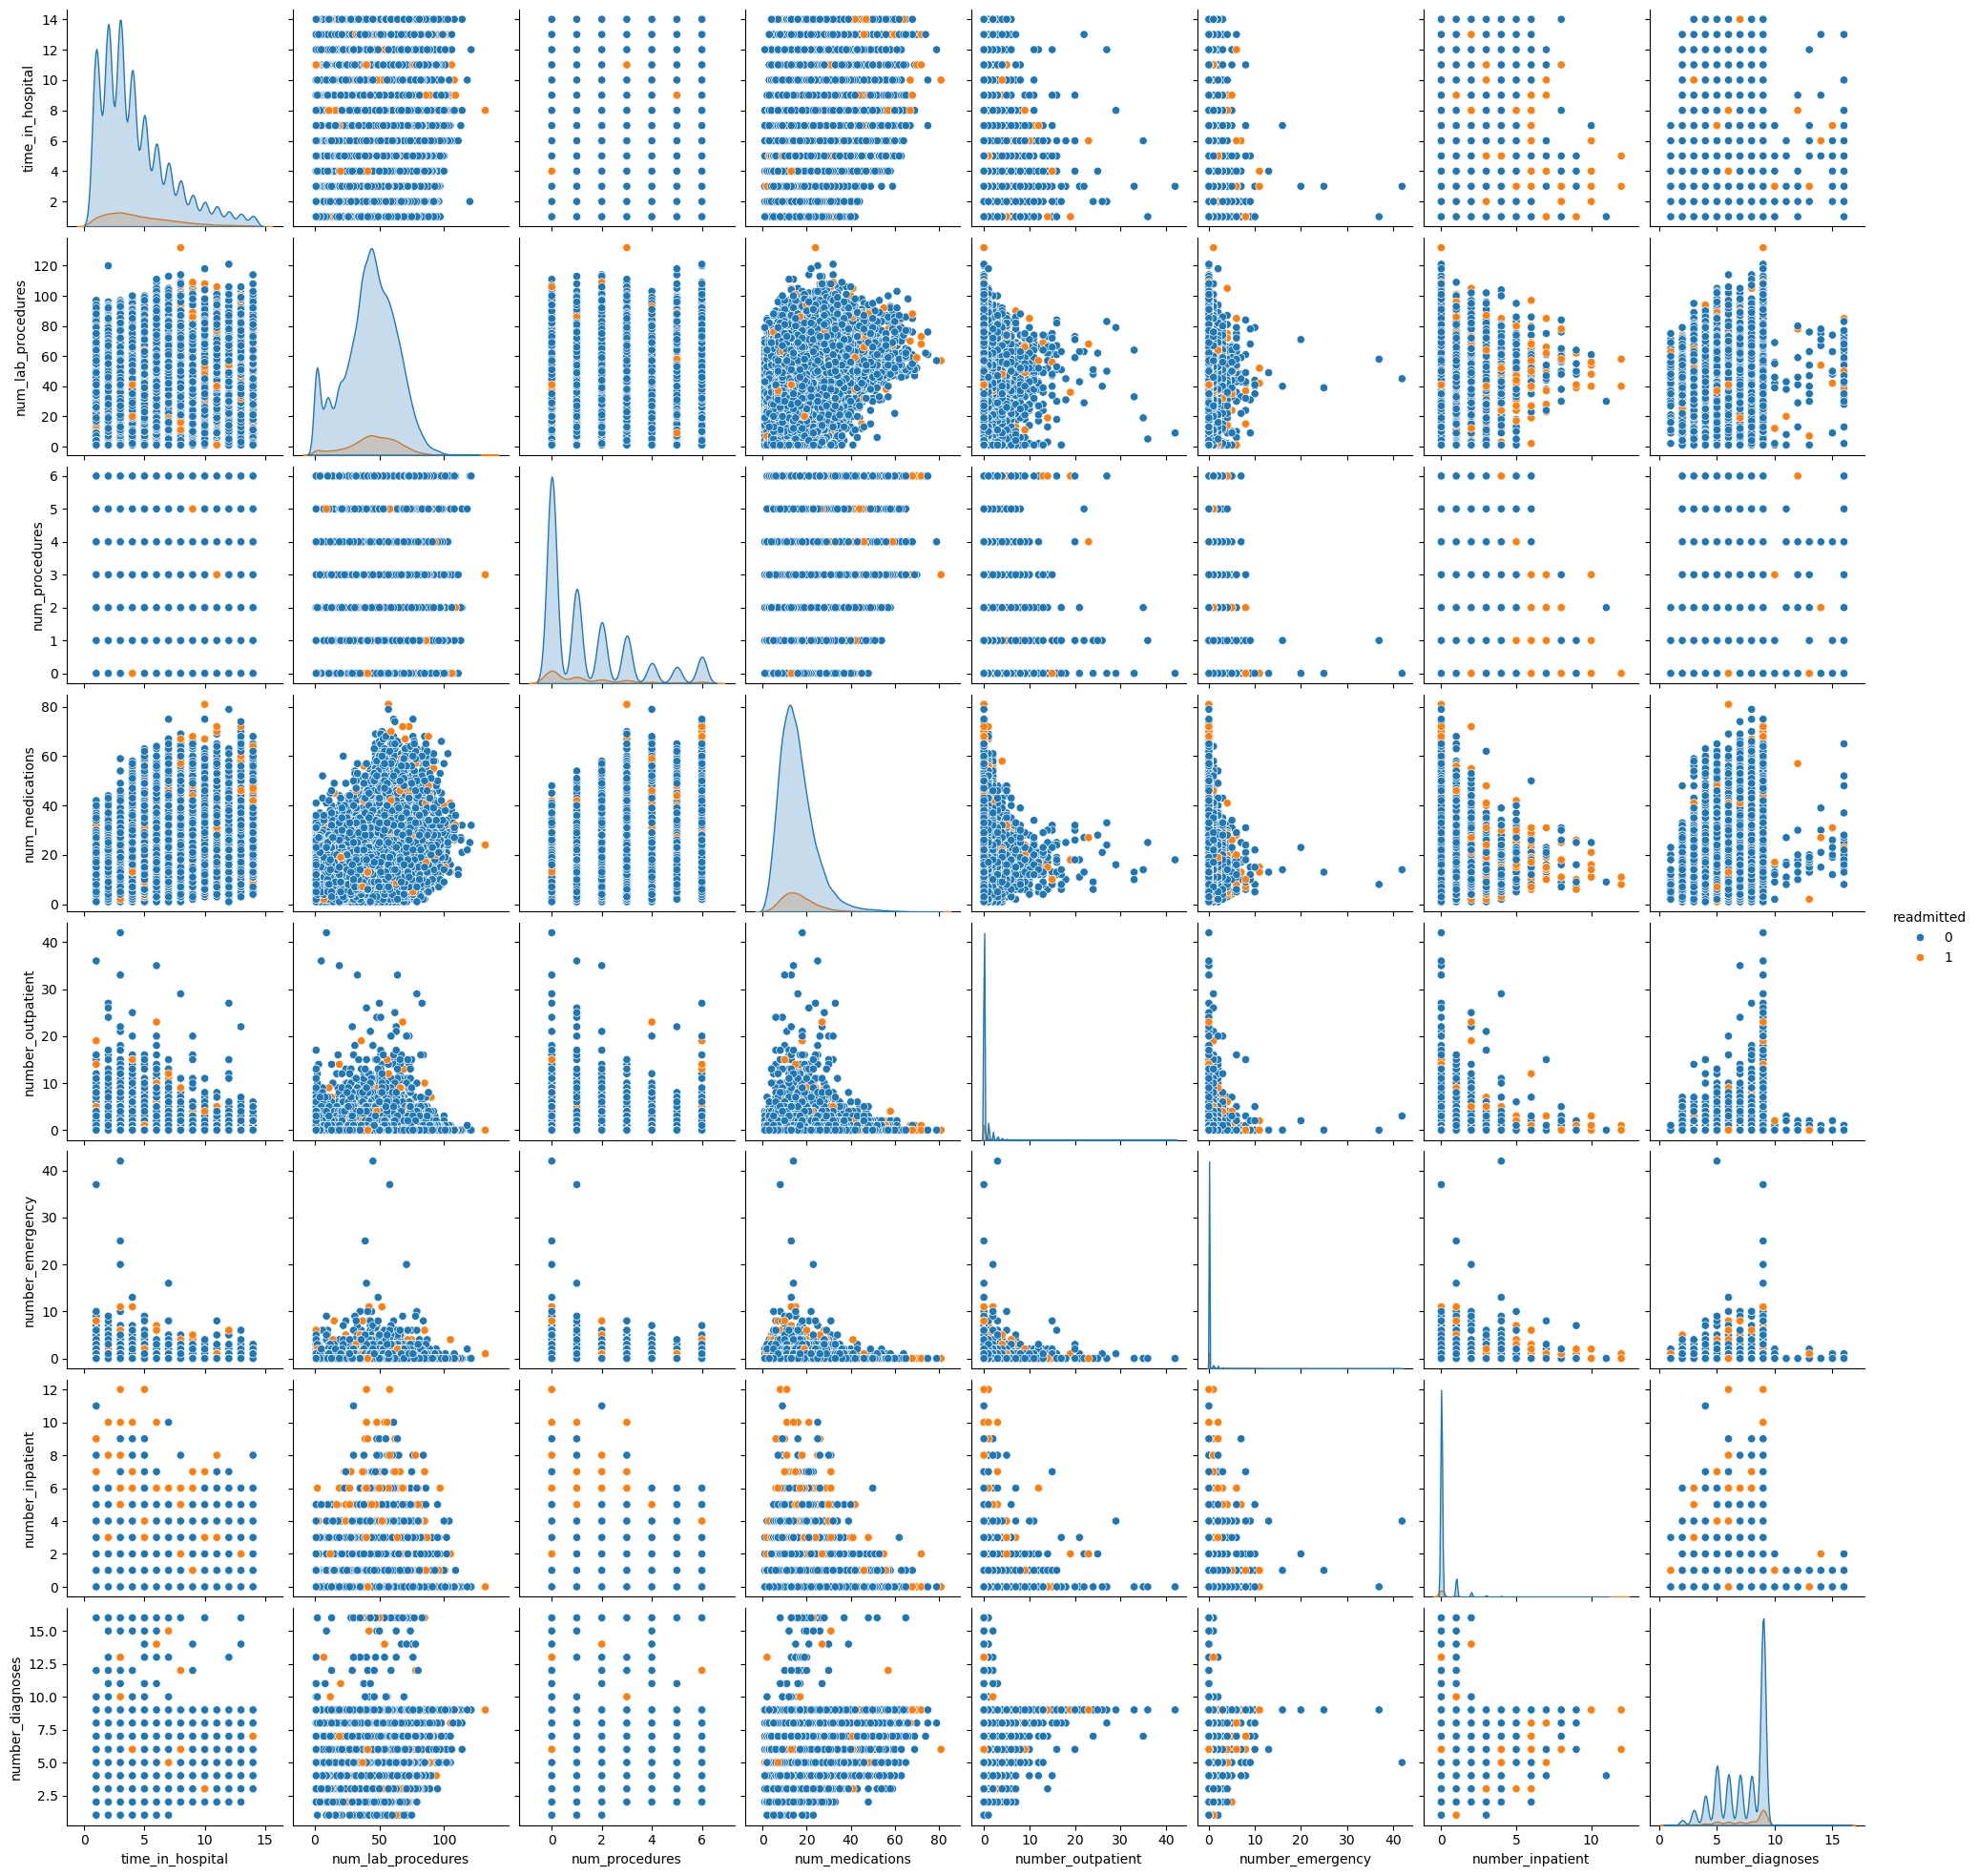

In [44]:
quant_col=df[['readmitted','time_in_hospital', 'num_lab_procedures', 'num_procedures','num_medications', 'number_outpatient', 'number_emergency',
       'number_inpatient', 'number_diagnoses']]

sns.pairplot(quant_col, hue="readmitted")

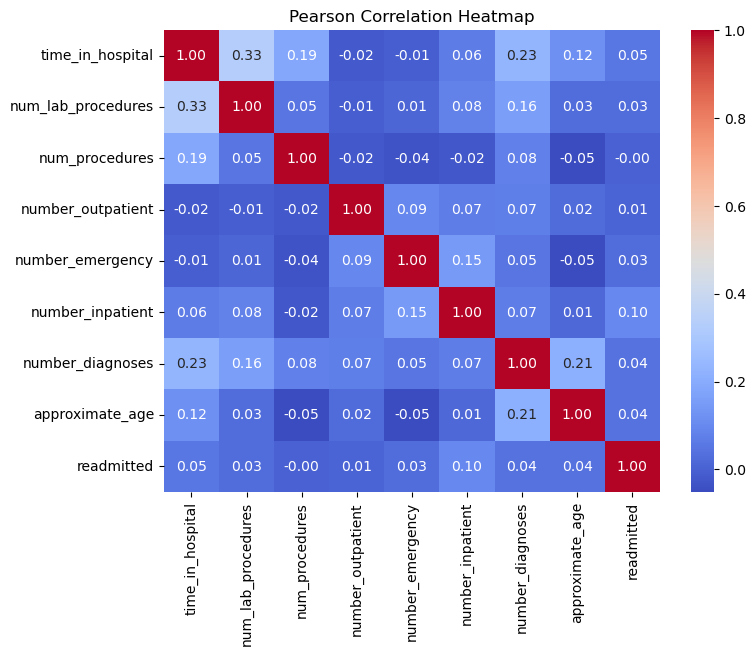

In [45]:
# Calculating Pearson correlation coefficient
correlation_matrix = df[numeric_cols + ['readmitted']].corr()

# Plotting heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Pearson Correlation Heatmap')
plt.show()

#### **Brief Binary EDA Summary**

It's clear that there is greater variance between the target categories now that they are binary. Additionally, converting the target to binary did not result in a significant change in the correlation of the numerical features with the target.

I'll proceed to split the data again and then move on to modeling.

## 2. Train-test split

In [46]:
# Splitting the data with the new target
X = df.drop(columns='readmitted')
y = df['readmitted']

# Splitting the dataset into training and testing sets while stratifying by the target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y, random_state=42)

# Calculate the size for the validation set to be 10% of the entire dataset
val_size = 0.1 / 0.9  # 10% of the whole dataset

# Further split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=val_size, stratify=y_train, random_state=42)

In [47]:
X_train = preprocess_pipeline.fit_transform(X_train)

## 3.Logistic Regression

The first binary classification model I'll train, hyperparameter tune, and then test is logistic regression.

Hyperparameter tuning will be conducted using k-fold cross-validation in order to undersample the data without causing data leakage.

In [48]:
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state=42)
classifier.fit(X_train, y_train)

X_val = preprocess_pipeline.transform(X_val)

# Predict the labels for the test set
y_pred = classifier.predict(X_val)

# Generate a classification report
report = classification_report(y_val, y_pred)

# Print the classification report
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

           0       0.91      1.00      0.95      6456
           1       0.62      0.01      0.02       626

    accuracy                           0.91      7082
   macro avg       0.77      0.50      0.48      7082
weighted avg       0.89      0.91      0.87      7082



In [51]:
from sklearn.model_selection import StratifiedKFold

# Define StratifiedKFold for outer cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'class_weight': [None, 'balanced', {0: 1, 1: 5}, {0: 1, 1: 10}]
}

# Initialize Logistic Regression classifier
logistic_regression = LogisticRegression(random_state=42)

# Initialize RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, cv=outer_cv, scoring='precision', verbose=2)

# Perform nested cross-validation
for train_index, val_index in outer_cv.split(X_train, y_train):
    # Split data into training and validation sets for this fold
    X_train_outer, X_val_outer = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_outer, y_val_outer = y_train.iloc[train_index], y_train.iloc[val_index]
    
    # Apply undersampling to the training data for this fold
    X_train_us, y_train_us = rus.fit_resample(X_train_outer, y_train_outer)
    
    # Fit GridSearchCV to the training data for this fold
    grid_search.fit(X_train_us, y_train_us)
    
    # Get the best estimator from GridSearchCV
    best_logistic_regression = grid_search.best_estimator_
    
    # Predict on validation data using the best estimator for this fold
    y_pred_val = best_logistic_regression.predict(X_val_outer)
    
    # Generate classification report for this fold
    report = classification_report(y_val_outer, y_pred_val)
    
    # Print the report for each fold
    print(report)

# Print the best parameters found by GridSearchCV
print("Best parameters found by GridSearchCV:", grid_search.best_params_)

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .............C=0.001, class_weight=None, penalty=l1; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l1; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l1; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l1; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l1; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l2; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l2; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l2; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l2; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l2; total time=   0.0s
[CV] END .........C=0.001, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END .........C=0.001, class_weight=balance

/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ............C=10, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.1s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.1s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.1s
[CV] END .......C=10, class_weight={0: 1, 1: 10}, penalty=l1; total time=   0.0s
[CV] END .......C=10, class_

/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

[CV] END ...........C=100, class_weight=balanced, penalty=l2; total time=   0.0s
[CV] END ...........C=100, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END ...........C=100, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END ...........C=100, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END ...........C=100, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.0s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.0s
[CV] END .......C=100, class

/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......C=100, class_weight={0: 1, 1: 10}, penalty=l2; total time=   0.1s
[CV] END ......C=100, class_weight={0: 1, 1: 10}, penalty=l2; total time=   0.0s
[CV] END ......C=100, class_weight={0: 1, 1: 10}, penalty=l2; total time=   0.0s
[CV] END ......C=100, class_weight={0: 1, 1: 10}, penalty=l2; total time=   0.1s


/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

              precision    recall  f1-score   support

           0       0.94      0.68      0.79     10328
           1       0.14      0.53      0.22      1003

    accuracy                           0.66     11331
   macro avg       0.54      0.60      0.50     11331
weighted avg       0.87      0.66      0.74     11331

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .............C=0.001, class_weight=None, penalty=l1; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l1; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l1; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l1; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l1; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l2; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l2; total time=   0.0s
[CV] END .............C=0.001, class_weight=

/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ................C=10, class_weight=None, penalty=l2; total time=   0.1s
[CV] END ................C=10, class_weight=None, penalty=l2; total time=   0.1s
[CV] END ................C=10, class_weight=None, penalty=l2; total time=   0.0s
[CV] END ................C=10, class_weight=None, penalty=l2; total time=   0.1s
[CV] END ............C=10, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ............C=10, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ............C=10, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ............C=10, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ............C=10, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ............C=10, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END ............C=10, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END ............C=10, class_weight=balanced, penalty=l2; total time=   0.1s


/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ............C=10, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END ............C=10, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.1s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.1s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.0s
[CV] END .......C=10, class_

/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

[CV] END ...............C=100, class_weight=None, penalty=l2; total time=   0.1s
[CV] END ...............C=100, class_weight=None, penalty=l2; total time=   0.1s
[CV] END ...............C=100, class_weight=None, penalty=l2; total time=   0.1s


/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............C=100, class_weight=None, penalty=l2; total time=   0.2s
[CV] END ...............C=100, class_weight=None, penalty=l2; total time=   0.1s
[CV] END ...........C=100, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ...........C=100, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ...........C=100, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ...........C=100, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ...........C=100, class_weight=balanced, penalty=l1; total time=   0.0s


/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

[CV] END ...........C=100, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END ...........C=100, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END ...........C=100, class_weight=balanced, penalty=l2; total time=   0.1s


/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

[CV] END ...........C=100, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END ...........C=100, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.1s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.1s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.1s


/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.1s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.1s
[CV] END ......C=100, class_weight={0: 1, 1: 10}, penalty=l1; total time=   0.0s
[CV] END ......C=100, class_weight={0: 1, 1: 10}, penalty=l1; total time=   0.0s
[CV] END ......C=100, class_weight={0: 1, 1: 10}, penalty=l1; total time=   0.0s
[CV] END ......C=100, class_weight={0: 1, 1: 10}, penalty=l1; total time=   0.0s
[CV] END ......C=100, class_weight={0: 1, 1: 10}, penalty=l1; total time=   0.0s
[CV] END ......C=100, class_weight={0: 1, 1: 10}, penalty=l2; total time=   0.1s
[CV] END ......C=100, class_weight={0: 1, 1: 10}, penalty=l2; total time=   0.1s
[CV] END ......C=100, class_weight={0: 1, 1: 10}, penalty=l2; total time=   0.1s
[CV] END ......C=100, class_weight={0: 1, 1: 10}, penalty=l2; total time=   0.1s
[CV] END ......C=100, class_weight={0: 1, 1: 10}, penalty=l2; total time=   0.0s


/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

              precision    recall  f1-score   support

           0       0.94      0.67      0.78     10328
           1       0.13      0.52      0.21      1002

    accuracy                           0.66     11330
   macro avg       0.53      0.60      0.50     11330
weighted avg       0.86      0.66      0.73     11330

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .............C=0.001, class_weight=None, penalty=l1; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l1; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l1; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l1; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l1; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l2; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l2; total time=   0.0s
[CV] END .............C=0.001, class_weight=

/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ................C=10, class_weight=None, penalty=l2; total time=   0.1s
[CV] END ................C=10, class_weight=None, penalty=l2; total time=   0.1s
[CV] END ................C=10, class_weight=None, penalty=l2; total time=   0.1s


/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

[CV] END ................C=10, class_weight=None, penalty=l2; total time=   0.1s
[CV] END ............C=10, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ............C=10, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ............C=10, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ............C=10, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ............C=10, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ............C=10, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END ............C=10, class_weight=balanced, penalty=l2; total time=   0.1s


/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ............C=10, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END ............C=10, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END ............C=10, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s


/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.1s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.1s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.1s
[CV] END .......C=10, class_weight={0: 1, 1: 10}, penalty=l1; total time=   0.0s
[CV] END .......C=10, class_weight={0: 1, 1: 10}, penalty=l1; total time=   0.0s
[CV] END .......C=10, class_weight={0: 1, 1: 10}, penalty=l1; total time=   0.0s
[CV] END .......C=10, class_weight={0: 1, 1: 10}, penalty=l1; total time=   0.0s
[CV] END .......C=10, class_weight={0: 1, 1: 10}, penalty=l1; total time=   0.0s
[CV] END .......C=10, class_weight={0: 1, 1: 10}, penalty=l2; total time=   0.0s
[CV] END .......C=10, class_weight={0: 1, 1: 10}, penalty=l2; total time=   0.1s
[CV] END .......C=10, class_

/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

[CV] END ...............C=100, class_weight=None, penalty=l2; total time=   0.1s
[CV] END ...............C=100, class_weight=None, penalty=l2; total time=   0.1s
[CV] END ...............C=100, class_weight=None, penalty=l2; total time=   0.1s
[CV] END ...........C=100, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ...........C=100, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ...........C=100, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ...........C=100, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ...........C=100, class_weight=balanced, penalty=l1; total time=   0.0s


/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

[CV] END ...........C=100, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END ...........C=100, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END ...........C=100, class_weight=balanced, penalty=l2; total time=   0.0s
[CV] END ...........C=100, class_weight=balanced, penalty=l2; total time=   0.1s


/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

[CV] END ...........C=100, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.1s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.1s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.1s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.1s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.1s
[CV] END ......C=100, class_weight={0: 1, 1: 10}, penalty=l1; total time=   0.0s
[CV] END ......C=100, class_

/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

              precision    recall  f1-score   support

           0       0.94      0.67      0.78     10328
           1       0.14      0.56      0.23      1002

    accuracy                           0.66     11330
   macro avg       0.54      0.61      0.50     11330
weighted avg       0.87      0.66      0.73     11330

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .............C=0.001, class_weight=None, penalty=l1; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l1; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l1; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l1; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l1; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l2; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l2; total time=   0.0s
[CV] END .............C=0.001, class_weight=

/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ................C=10, class_weight=None, penalty=l2; total time=   0.1s
[CV] END ................C=10, class_weight=None, penalty=l2; total time=   0.1s
[CV] END ............C=10, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ............C=10, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ............C=10, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ............C=10, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ............C=10, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ............C=10, class_weight=balanced, penalty=l2; total time=   0.1s


/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ............C=10, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END ............C=10, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END ............C=10, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END ............C=10, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.0s
[CV] END ........C=10, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.0s
[CV] END ........C=10, class

/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...............C=100, class_weight=None, penalty=l2; total time=   0.1s
[CV] END ...............C=100, class_weight=None, penalty=l2; total time=   0.1s
[CV] END ...........C=100, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ...........C=100, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ...........C=100, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ...........C=100, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ...........C=100, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END ...........C=100, class_weight=balanced, penalty=l2; total time=   0.1s


/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-

[CV] END ...........C=100, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END ...........C=100, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END ...........C=100, class_weight=balanced, penalty=l2; total time=   0.1s
[CV] END ...........C=100, class_weight=balanced, penalty=l2; total time=   0.3s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l1; total time=   0.0s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.1s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.1s
[CV] END .......C=100, class_weight={0: 1, 1: 5}, penalty=l2; total time=   0.0s
[CV] END .......C=100, class

/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......C=100, class_weight={0: 1, 1: 10}, penalty=l2; total time=   0.0s
[CV] END ......C=100, class_weight={0: 1, 1: 10}, penalty=l2; total time=   0.1s
[CV] END ......C=100, class_weight={0: 1, 1: 10}, penalty=l2; total time=   0.1s
              precision    recall  f1-score   support

           0       0.93      0.69      0.79     10328
           1       0.13      0.50      0.21      1002

    accuracy                           0.67     11330
   macro avg       0.53      0.59      0.50     11330
weighted avg       0.86      0.67      0.74     11330

Fitting 5 folds for each of 48 candidates, totalling 240 fits
[CV] END .............C=0.001, class_weight=None, penalty=l1; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l1; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l1; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l1; total time=   0.0s
[CV] END .............C=0.001, class_weight=

/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

[CV] END .............C=0.001, class_weight=None, penalty=l2; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l2; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l2; total time=   0.0s
[CV] END .............C=0.001, class_weight=None, penalty=l2; total time=   0.0s
[CV] END .........C=0.001, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END .........C=0.001, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END .........C=0.001, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END .........C=0.001, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END .........C=0.001, class_weight=balanced, penalty=l1; total time=   0.0s
[CV] END .........C=0.001, class_weight=balanced, penalty=l2; total time=   0.0s
[CV] END .........C=0.001, class_weight=balanced, penalty=l2; total time=   0.0s
[CV] END .........C=0.001, class_weight=balanced, penalty=l2; total time=   0.0s
[CV] END .........C=0.001, c

/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
120 fits failed out of a total of 240.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
120 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/base.py", line 1474, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "

In [54]:
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)

best_log = LogisticRegression(C=0.1, class_weight=None, penalty='l2')

best_log.fit(X_train_us, y_train_us)

X_test = preprocess_pipeline.transform(X_test)

# Predict the labels for the test set
y_pred = classifier.predict(X_test)

# Generate a classification report
report = classification_report(y_test, y_pred)
print(report)

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      6456
           1       0.17      0.00      0.00       626

    accuracy                           0.91      7082
   macro avg       0.54      0.50      0.48      7082
weighted avg       0.85      0.91      0.87      7082



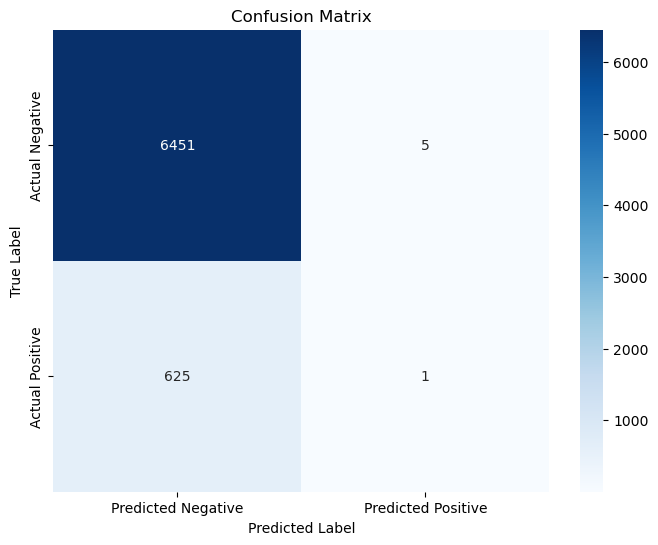

NameError: name 'roc_curve' is not defined

In [55]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

Text(0.5, 1.0, 'Receiver')

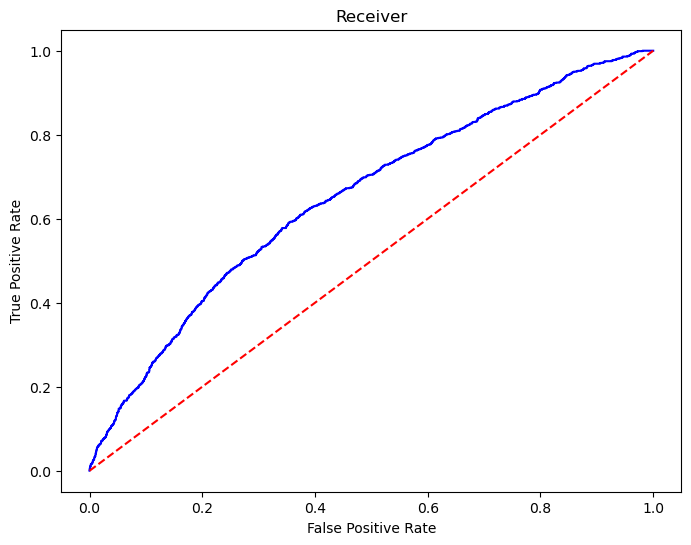

In [56]:
from sklearn.metrics import roc_curve, auc
# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_val_outer, best_logistic_regression.predict_proba(X_val_outer)[:, 1])

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label='ROC Curve')
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver') 

#### **Logistic Regression Summary**

Initially, I intended to use recall as my primary metric. However, this approach consistently led to my models predicting all instances as class 1, or readmitted. While this strategy technically minimizes false negatives (patients who are readmitted but not identified as at risk), it doesn't offer practical benefits. To address this issue, I've decided to prioritize precision. This metric helps balance out the number of false positives and provides a more practical evaluation of model performance.

Similar to the models with three categories for readmission, this binary classification model also struggles to effectively categorize the target class of interest. While the model performs reasonably well overall, it falls short of meeting the specific business requirements for accurately predicting early readmissions.

## 4.XGBoost

The second binary classification model I'll train, hyperparameter tune, and then test is XGBoost.

Hyperparameter tuning will be conducted using k-fold cross-validation in order to undersample the data without causing data leakage.

In [57]:
from xgboost import XGBClassifier

# Define the XGBoost model with default hyperparameters
xgb_model = XGBClassifier()

# Train the model
xgb_model.fit(X_train_us, y_train_us)

# Make predictions on the testing data
y_pred = xgb_model.predict(X_val)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_val, y_pred))

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.61      0.74      6456
           1       0.13      0.60      0.21       626

    accuracy                           0.61      7082
   macro avg       0.53      0.60      0.47      7082
weighted avg       0.87      0.61      0.69      7082



In [58]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler

# Define StratifiedKFold for outer cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.3]
}

# Initialize RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=XGBClassifier(), param_grid=param_grid, cv=outer_cv, scoring='precision')

# Perform grid search with undersampling
for train_index, val_index in outer_cv.split(X_train, y_train):
    # Split data into training and validation sets for this fold
    X_train_outer, X_val_outer = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_outer, y_val_outer = y_train.iloc[train_index], y_train.iloc[val_index]

    # Apply undersampling to the training data for this fold
    X_train_us, y_train_us = rus.fit_resample(X_train_outer, y_train_outer)

    # Fit GridSearchCV to the training data for this fold
    grid_search.fit(X_train_us, y_train_us)

# Get the best parameters
best_params = grid_search.best_params_

# Instantiate a new XGBoost model with the best parameters
best_xgb_model = XGBClassifier(**best_params)

# Train the best model on the entire training data with undersampling
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)
best_xgb_model.fit(X_train_us, y_train_us)

# Make predictions on the validation set
y_pred_val = best_xgb_model.predict(X_val)

# Print classification report
print("Classification Report on Validation Set:")
print(classification_report(y_val, y_pred_val))

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.94      0.64      0.76      6456
           1       0.14      0.60      0.22       626

    accuracy                           0.64      7082
   macro avg       0.54      0.62      0.49      7082
weighted avg       0.87      0.64      0.71      7082



In [60]:
#X_test = preprocess_pipeline.transform(X_test)
y_pred_test = best_xgb_model.predict(X_test)

# Print classification report
print("Classification Report on Validation Set:")
print(classification_report(y_test, y_pred_test))

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.94      0.64      0.76      6456
           1       0.13      0.55      0.21       626

    accuracy                           0.63      7082
   macro avg       0.53      0.60      0.49      7082
weighted avg       0.87      0.63      0.71      7082



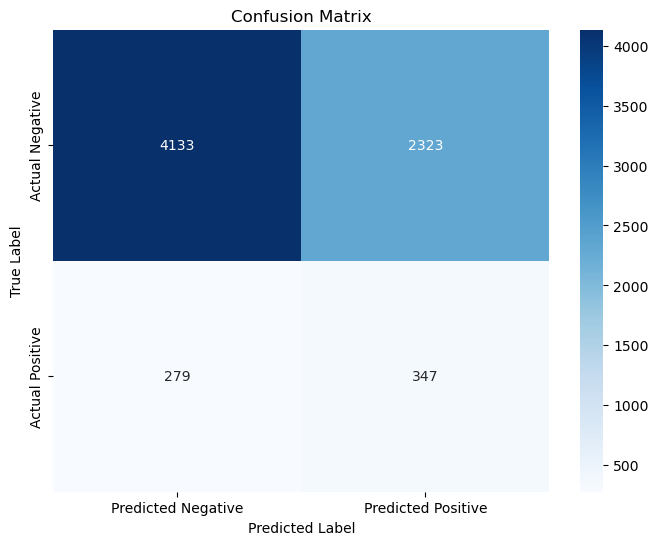

In [61]:
# Calculate confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)

# Plot confusion matrix heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", 
            xticklabels=['Predicted Negative', 'Predicted Positive'], 
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### **XGBoost Summary**

XGBoost's final model did much better at categorizing the focus class than logistic regression

However, recall for class 1 is 0.55, indicating that the model captures 55% of all actual instances of class 1 in the dataset. While this suggests a relatively higher sensitivity compared to precision, it still indicates that the model misses a considerable portion of class 1 instances.

## 5. Random Forest

Next I will train, hyperparameter tune, and then test a Random Forest.

Hyperparameter tuning will be conducted using k-fold cross-validation in order to undersample the data without causing data leakage.

In [62]:
# Define the Random Forest model
random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

random_forest.fit(X_train_us, y_train_us)

# Predict on validation data using the best estimator
y_val_pred = random_forest.predict(X_val)

# Generate classification report
report = classification_report(y_val, y_val_pred)

# Print the report
print(report)

              precision    recall  f1-score   support

           0       0.94      0.60      0.74      6456
           1       0.13      0.60      0.21       626

    accuracy                           0.60      7082
   macro avg       0.53      0.60      0.47      7082
weighted avg       0.87      0.60      0.69      7082



In [67]:
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import classification_report

# Define the parameter grid for hyperparameter tuning
param_grid_rf = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Initialize RandomForestClassifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Define StratifiedKFold for outer cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV for RandomForestClassifier
grid_search_rf = GridSearchCV(estimator=rf_classifier, param_grid=param_grid_rf, cv=outer_cv, scoring='precision', verbose=2)

# Perform grid search with undersampling for RandomForestClassifier
for train_index, val_index in outer_cv.split(X_train, y_train):
    # Split data into training and validation sets for this fold
    X_train_outer, X_val_outer = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_outer, y_val_outer = y_train.iloc[train_index], y_train.iloc[val_index]

    # Apply undersampling to the training data for this fold
    X_train_us, y_train_us = rus.fit_resample(X_train_outer, y_train_outer)

    # Fit GridSearchCV to the training data for this fold
    grid_search_rf.fit(X_train_us, y_train_us)

# Get the best parameters for RandomForestClassifier
best_params_rf = grid_search_rf.best_params_

# Instantiate a new RandomForestClassifier with the best parameters
best_rf_model = RandomForestClassifier(**best_params_rf, random_state=42)

# Train the best RandomForestClassifier model on the entire training data with undersampling
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)
best_rf_model.fit(X_train_us, y_train_us)

# Make predictions on the validation set using the best RandomForestClassifier model
y_pred_val_rf = best_rf_model.predict(X_val)

# Print classification report for RandomForestClassifier
print("Classification Report on Validation Set for RandomForestClassifier:")
print(classification_report(y_val, y_pred_val_rf))

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.2s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.4s
[CV] END bootstrap=True, max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total tim

In [68]:
print(best_params_rf)

{'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}


In [70]:
feature_labels = X_train.columns
# Extract feature importances
importances = best_rf_model.feature_importances_

# Match feature importances with their corresponding labels
feature_importance_dict = dict(zip(feature_labels, importances))

# Sort feature importances by value in descending order
sorted_feature_importances = sorted(feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

# Print feature importances
print("\nFeature Importances:")
for feature, importance in sorted_feature_importances:
    print(f"{feature}: {importance:.4f}")


Feature Importances:
number_inpatient: 0.0979
discharge_dispo_home: 0.0969
num_lab_procedures: 0.0850
time_in_hospital: 0.0686
discharge_dispo_SNF/ICF: 0.0676
approximate_age: 0.0624
number_diagnoses: 0.0525
discharge_dispo_expired: 0.0497
num_procedures: 0.0405
number_outpatient: 0.0243
number_emergency: 0.0242
discharge_dispo_specialty hospital: 0.0212
primary_diagnosis_Respiratory: 0.0148
gender_1: 0.0126
discharge_dispo_home with home health: 0.0125
primary_diagnosis_Circulatory: 0.0119
admission_source_emergency room: 0.0119
gender_0: 0.0114
any_diabetes_med_1: 0.0111
insulin_1: 0.0110
admission_type_elective: 0.0110
admission_source_referral: 0.0106
any_diabetes_med_0: 0.0104
admission_type_urgent: 0.0103
admission_type_emergent: 0.0102
primary_diagnosis_Neoplasms: 0.0102
insulin_0: 0.0097
primary_diagnosis_Musculoskeletal: 0.0095
admission_type_NA: 0.0094
admission_source_hospital transfer: 0.0083
primary_diagnosis_Genitourinary: 0.0081
admission_source_NA: 0.0080
primary_diagn

In [72]:
# Per our PCA, selecting top 12 features based on importance
selected_features = ['number_inpatient',
'discharge_dispo_home',
'num_lab_procedures',
'time_in_hospital',
'discharge_dispo_SNF/ICF',
'approximate_age',
'number_diagnoses',
'discharge_dispo_expired',
'num_procedures',
'number_outpatient',
'number_emergency',
'discharge_dispo_specialty hospital'
]

X_train_subset = X_train_us[selected_features]  
X_val_subset = X_val[selected_features]  

# Initialize Random Forest classifier {'bootstrap': False, 'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 150}
random_forest1 = RandomForestClassifier(bootstrap=False, max_depth=10, min_samples_leaf=1, min_samples_split=10, n_estimators=150, random_state=42)

# Fit the model on the training data
random_forest1.fit(X_train_subset, y_train_us)

# Predict on the testing data
y_pred = random_forest1.predict(X_val_subset)

# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

# Print out all scores
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Accuracy: 0.6212934199378707
Precision: 0.13285714285714287
Recall: 0.5942492012779552
F1 Score: 0.2171628721541156


In [76]:
# Predict on the testing data
y_pred = random_forest1.predict(X_val_subset)

# Print classification report
print("Classification Report on Validation Set:")
print(classification_report(y_val, y_pred))

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.94      0.62      0.75      6456
           1       0.13      0.59      0.22       626

    accuracy                           0.62      7082
   macro avg       0.54      0.61      0.48      7082
weighted avg       0.87      0.62      0.70      7082



In [77]:
X_test_subset = X_test[selected_features]

y_pred = random_forest1.predict(X_test_subset)

# Print classification report
print("Classification Report on Validation Set:")
print(classification_report(y_test, y_pred))

Classification Report on Validation Set:
              precision    recall  f1-score   support

           0       0.93      0.62      0.74      6456
           1       0.12      0.55      0.20       626

    accuracy                           0.61      7082
   macro avg       0.53      0.58      0.47      7082
weighted avg       0.86      0.61      0.70      7082



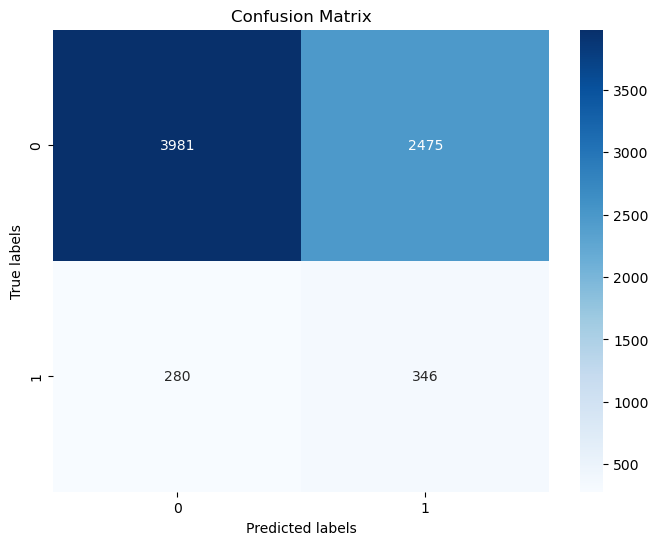

In [79]:
# Confusion Matrix Heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', annot_kws={"size": 10})
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

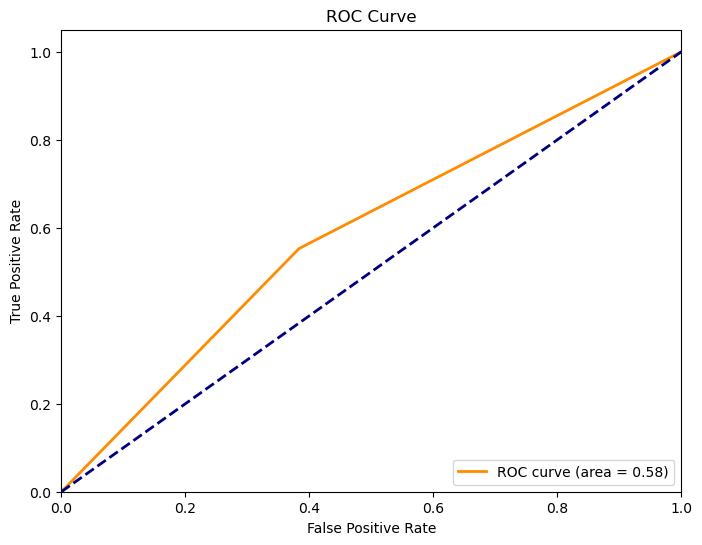

In [80]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

#### **Random Forest Summary**
Hyperparametric Tuning the Random Forest did result in a model that did better than XG Boost, but marginally. And according to my metric, precision it did worse.

Feature importance did not seem to improve the model in a significant way.

## 6. Adaboost

The final model I will attempt is AdaBoost.

In [82]:
from sklearn.ensemble import AdaBoostClassifier

# Initialize AdaBoost classifier
adaboost = AdaBoostClassifier(random_state=42)

# Fit the classifier on the training data
adaboost.fit(X_train_us, y_train_us)

# Predict on the testing data
y_pred = adaboost.predict(X_val)

# Calculate evaluation metrics
accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
report = classification_report(y_val, y_pred)

# Print out all scores
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)
print("Classification Report:\n", report)

/Users/rebekahmclaughlin/anaconda3/envs/learn-env/lib/python3.11/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Accuracy: 0.6530641061846936
Precision: 0.14280140460397972
Recall: 0.5846645367412141
F1 Score: 0.2295390404515522
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.66      0.78      6456
           1       0.14      0.58      0.23       626

    accuracy                           0.65      7082
   macro avg       0.54      0.62      0.50      7082
weighted avg       0.87      0.65      0.73      7082



# Initialize AdaBoost classifier
adaboost = AdaBoostClassifier(random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid_adaboost = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.01, 0.1, 1]
}

# Initialize RandomUnderSampler
rus = RandomUnderSampler(random_state=42)

# Define StratifiedKFold for outer cross-validation
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize GridSearchCV for AdaBoostClassifier
grid_search_adaboost = GridSearchCV(estimator=adaboost, param_grid=param_grid_adaboost, cv=outer_cv, scoring='precision', verbose=2)

# Perform grid search with undersampling for AdaBoostClassifier
for train_index, val_index in outer_cv.split(X_train, y_train):
    # Split data into training and validation sets for this fold
    X_train_outer, X_val_outer = X_train.iloc[train_index], X_train.iloc[val_index]
    y_train_outer, y_val_outer = y_train.iloc[train_index], y_train.iloc[val_index]

    # Apply undersampling to the training data for this fold
    X_train_us, y_train_us = rus.fit_resample(X_train_outer, y_train_outer)

    # Fit GridSearchCV to the training data for this fold
    grid_search_adaboost.fit(X_train_us, y_train_us)

# Get the best parameters for AdaBoostClassifier
best_params_adaboost = grid_search_adaboost.best_params_

# Instantiate a new AdaBoostClassifier with the best parameters
best_adaboost_model = AdaBoostClassifier(**best_params_adaboost, random_state=42)

# Train the best AdaBoostClassifier model on the entire training data with undersampling
X_train_us, y_train_us = rus.fit_resample(X_train, y_train)
best_adaboost_model.fit(X_train_us, y_train_us)

# Make predictions on the validation set using the best AdaBoostClassifier model
y_pred_val_adaboost = best_adaboost_model.predict(X_val)

# Print classification report for AdaBoostClassifier
print("Classification Report on Validation Set for AdaBoostClassifier:")
print(classification_report(y_val, y_pred_val_adaboost))

In [84]:
# Print classification report for AdaBoostClassifier
print("Classification Report on Validation Set for AdaBoostClassifier:")
print(classification_report(y_val, y_pred_val_adaboost))

Classification Report on Validation Set for AdaBoostClassifier:
              precision    recall  f1-score   support

           0       0.94      0.65      0.77      6456
           1       0.14      0.59      0.23       626

    accuracy                           0.65      7082
   macro avg       0.54      0.62      0.50      7082
weighted avg       0.87      0.65      0.72      7082



#### **AdaBoost Summary**
Adaboost's results are on-par with the other models that have used undersampling.

# IIII. Results
## 1. Modeling and Limitations
While this notebook doesn't encompass exhaustive evidence of every model and fine-tuning attempt I made, it does showcase two primary approaches I explored. Given more time, I would have also liked to include examples of oversampling techniques.

I'd also like to try more ensembling and stacking methods.

Overall, the models achieved an accuracy of around 60%, with particularly poor performance in identifying the target class. Upon comparing my work with the efforts of others, I am inclined to believe that this dataset may not be inherently conducive to accurate predictive modeling for this specific task.

Ideally, I would seek input from individuals with more experience and expertise to assess the suitability of this dataset for predictive modeling purposes.

## 2. Project Gains

While I didn't achieve the initial objectives I set out for, this project provided valuable learning opportunities.

On a personal level, I gained insights into various challenges and strategies associated with handling an imbalanced target variable.

Furthermore, the features identified as significant can serve as valuable starting points for further research into readmission risk factors.